<a href="https://colab.research.google.com/github/rachboyle/mixed_methods_b2b_personas_generation/blob/main/clustering_iterations_3_and_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Web Analytics Clustering: 3rd and 4th Iterations

In [ ]:
#Authenticate to GCP to access survey and web analytics data in BigQuery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


##Iterative Mixed Method Approach to B2B SaaS User Personas Overview
Below is an overview of the various analysis and clustering steps we took for our persona generation research. This particular notebook focuses on the step(s) highlighted in yellow: 

1.   **Survey Data Pre-Processing**: Survey data cleaning and pre-processing
2.   **Survey Clustering**: Initial survey clustering to produce rudimentary personas we could use for interview recruitment
3.   **Analytcs Data Pre-Processing**: Web analytics data (from [Pendo](https://www.pendo.io) tool) pre-processing, manipulation, and sanitization tool
4.   **Preprocessing and Clustering Iterations**: Four iterations of preprocessing and clustering on the web analytics data; the following iterations listed below contain the clustering algorithm, dimensionality reduction method, and data pre-processing manipulation respectively
    * *KMeans, PCA, Averaged Data*
    * *KMeans, PCA, Percentage Usage Data Per Day*
    * <mark>*KMeans, UMAP, Percentage Usage Data Per Day*
    * <mark>*HDBScan, UMAP, Percentage Usage Data Per Week*







##Imports

In [ ]:
#Install UMAP (dimensionality reduction) and HDBscan (clustering algorithm)
!pip install umap-learn
!pip install hdbscan

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from IPython.display import display_html
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
plt.rcParams.update({'figure.max_open_warning': 0}) #set so you do not get warnings

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering libraries
import umap.umap_ as umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import normalize, StandardScaler

##Iteration 3: KMeans, UMAP, Daily Percentage Data
This iteration kept the preprocessing and clustering algorithm the same, but changed the dimensionality reduction to be one more suited for the sparse, categorical dataset and included an expanded the clustering features to include core CTAs. The resulting seven personas (one not pictured in the above graph and hardcoded due to the use of a separate product in our suite, Advanced TV) seemed the most promising, but when communicated to internal stakeholders and teams caused some confusion. The main issue with this iteration was the concept of a “Distributor” persona, who mainly focuses on advertising distribution / activation. This was a sticky point since this task was seen as universal both internally and through the analytics data, a common and perhaps even necessary action to using the platform and not one that would warrant its own, separate persona. It was unclear if this was simply an interpretation / language problem or clustering one.

###Clustering

In [ ]:
%%bigquery --project uxr-design-us-dev percentage_per_day_combined_df
SELECT * EXCEPT (email, cluster, interviewed)
FROM `uxr-design-us-dev.clustering_datasets.ave_clicks_important_features_clustering_data` f
INNER JOIN `uxr-design-us-dev.clustering_datasets.personas_from_percentage_page_data` p
ON f.visitor_id = p.visitor_id

In [ ]:
#Grabbing the ids and names to create a table of relevant clustering features
%%bigquery --project uxr-design-us-dev id_name_mapping
SELECT distinct feature_id as id, feature_name as name, page_id as parent_id, page_name as parent_name, group_name, is_core_event, app, "feature" as type 
FROM `mixed_methods_clustering.all_features_telemetry_data_per_week_deduped`

UNION ALL

SELECT distinct page_id as id, page_name as name, "" as parent_id, "" as parent_name, group_name, False as is_core_event, app, "page" as type 
FROM `mixed_methods_clustering.all_pages_telemetry_data_per_week_deduped`

In [ ]:
#Separate out the advanced tv users since through user interviews we have established them as a separate cluster
non_adv_tv_df = percentage_per_day_combined_df[~((percentage_per_day_combined_df["cnt_app"] == 2) | (percentage_per_day_combined_df["persona_label"] == "tv_builder") | (percentage_per_day_combined_df["visitor_id"].str.contains("-")))]

adv_tv_df = percentage_per_day_combined_df[((percentage_per_day_combined_df["cnt_app"] == 2) | (percentage_per_day_combined_df["persona_label"] == "tv_builder") | (percentage_per_day_combined_df["visitor_id"].str.contains("-")))]
adv_tv_df["persona"] = "tv_user"
adv_tv_df.drop(columns=["persona_label", "cnt_app"], inplace=True)
non_adv_tv_df.drop(columns=["persona_label", "cnt_app"], inplace=True)

In [ ]:
percentage_per_day_combined_df = non_adv_tv_df

#Since the data is combined, drop the duplicate visitor_id column
percentage_per_day_combined_df = percentage_per_day_combined_df.drop(columns= ["visitor_id_1"])

#The dataset has columns that were incorrectly formatted- adjust here
percentage_per_day_combined_df = percentage_per_day_combined_df.rename(columns={"_visitor_id":"visitor_id"})

#IDs of the relevant pages and features in the average percentage dataset
ids = percentage_per_day_combined_df.columns.to_list()[1::]

#Create mapping table of reformatted id to name
id_name_mapping["reformatted_id"] = "_" + id_name_mapping["id"].str.replace('-', '_')
id_name_mapping = id_name_mapping[id_name_mapping["reformatted_id"].isin(ids)]

#Create list of page names and ids
page_names = id_name_mapping[id_name_mapping["type"] == "page"]["name"].to_list()
p_ids = id_name_mapping[id_name_mapping["type"] == "page"]["reformatted_id"].to_list()

#Create list of feature names and ids
feature_names = id_name_mapping[id_name_mapping["type"] == "feature"]["name"].to_list()
f_ids = id_name_mapping[id_name_mapping["type"] == "feature"]["reformatted_id"].to_list()

feature_ids = p_ids + f_ids
len(feature_ids)

80

In [ ]:
# Scaling the data to bring all the attributes to a comparable level
scaler = StandardScaler()
X_scaled = scaler.fit_transform(percentage_per_day_combined_df[ids])

# Normalizing the data so that the data
# approximately follows a Gaussian distribution
X_normalized = normalize(X_scaled)

# Converting the numpy array into a pandas DataFrame
X_normalized = pd.DataFrame(X_normalized)

# Renaming the columns
X_normalized.columns = ids

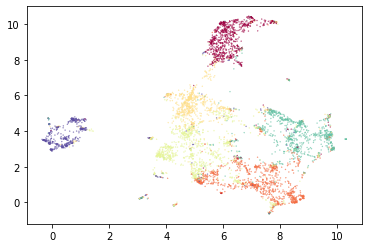

In [ ]:
#Create an embedding of the data to reduce the dimensionality
clusterable_embedding = umap.UMAP(
    n_neighbors=60,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(X_normalized)


kmeans_umap_labels = cluster.KMeans(n_clusters=6).fit_predict(X_normalized)
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], \
            c=kmeans_umap_labels, s=0.1, cmap='Spectral');

In [ ]:
cluster_name = "clustering_iter_3"
percentage_per_day_combined_df[cluster_name] = kmeans_umap_labels
kmeans_summary_3 = percentage_per_day_combined_df.groupby([cluster_name]).mean()
kmeans_summary_3['count'] = percentage_per_day_combined_df[cluster_name].value_counts()
kmeans_summary_3 = kmeans_summary_3.sort_values(by='count', ascending=False)

kmeans_summary_3['count']

clustering_iter_3
3    1007
1    1006
4     942
0     837
2     778
5     516
Name: count, dtype: int64

###Per Cluster Breakdown



PERSONA CLUSTER: 0 

NUMBER OF USERS IN CLUSTER: 837.0 

PERCENTAGE OF USERS IN CLUSTER: 16.457 



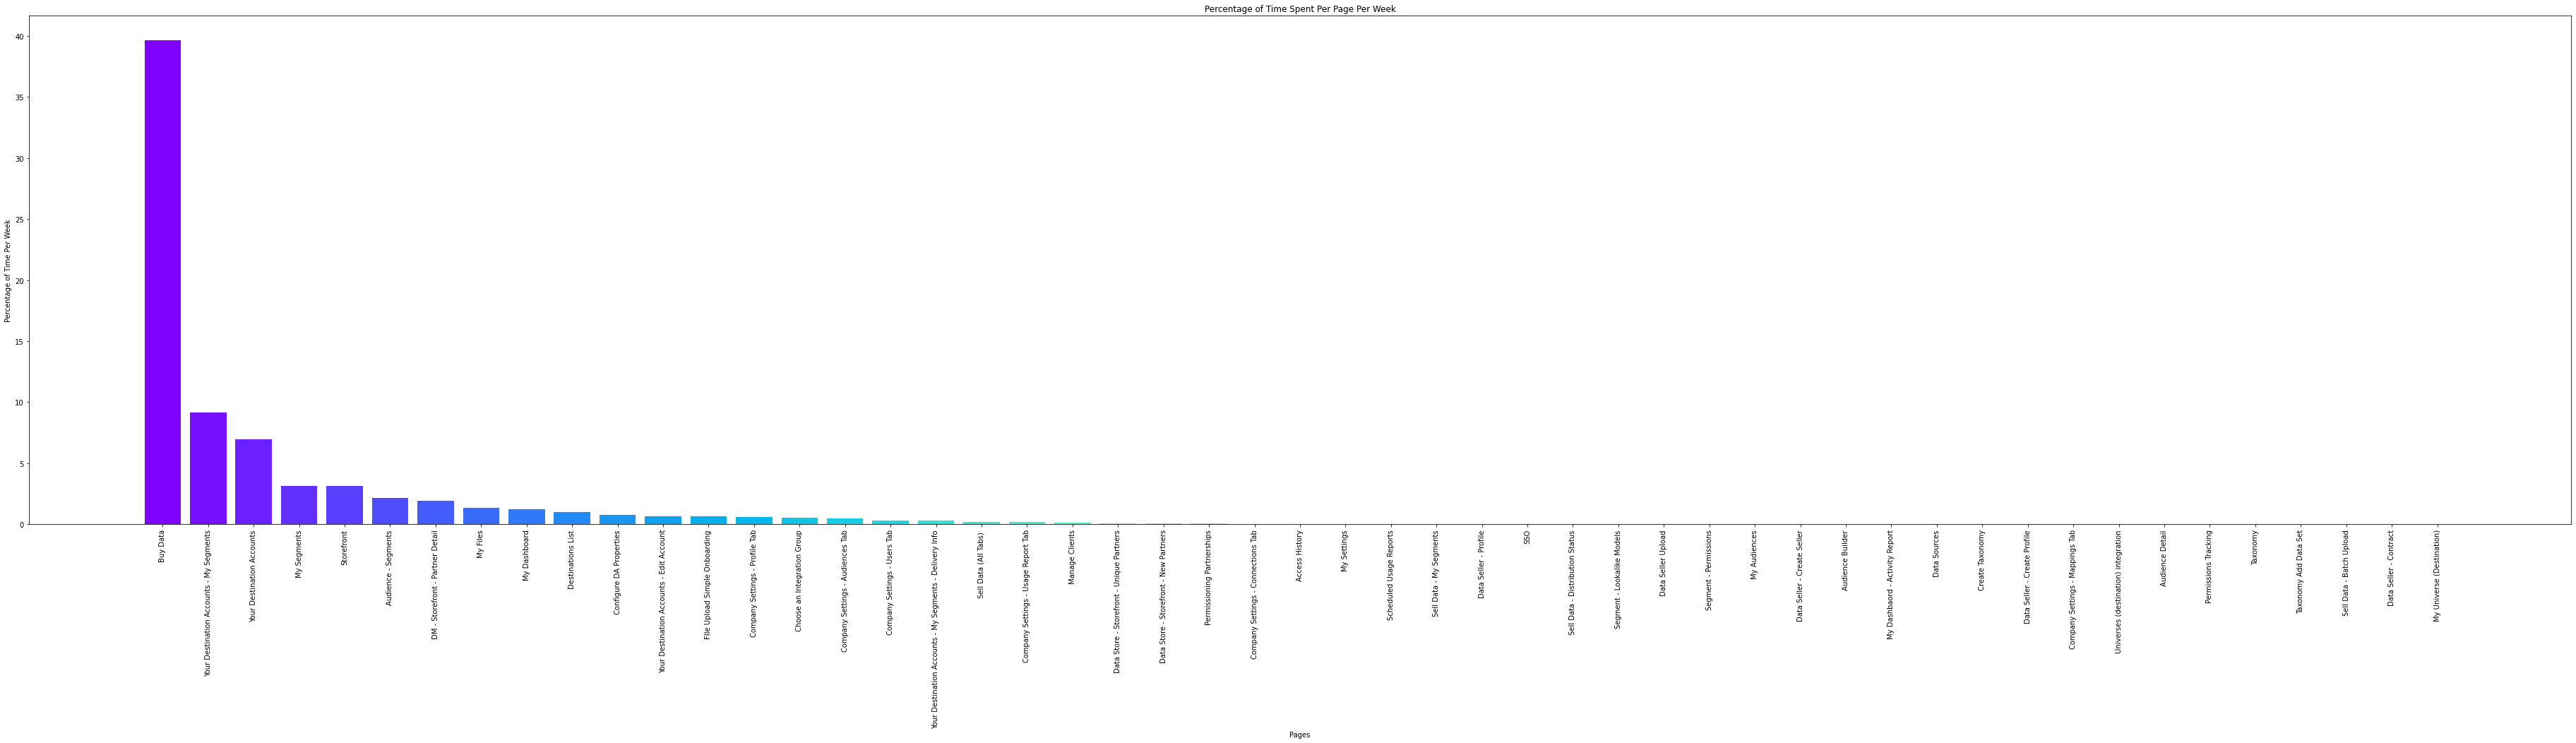

<Figure size 432x288 with 0 Axes>

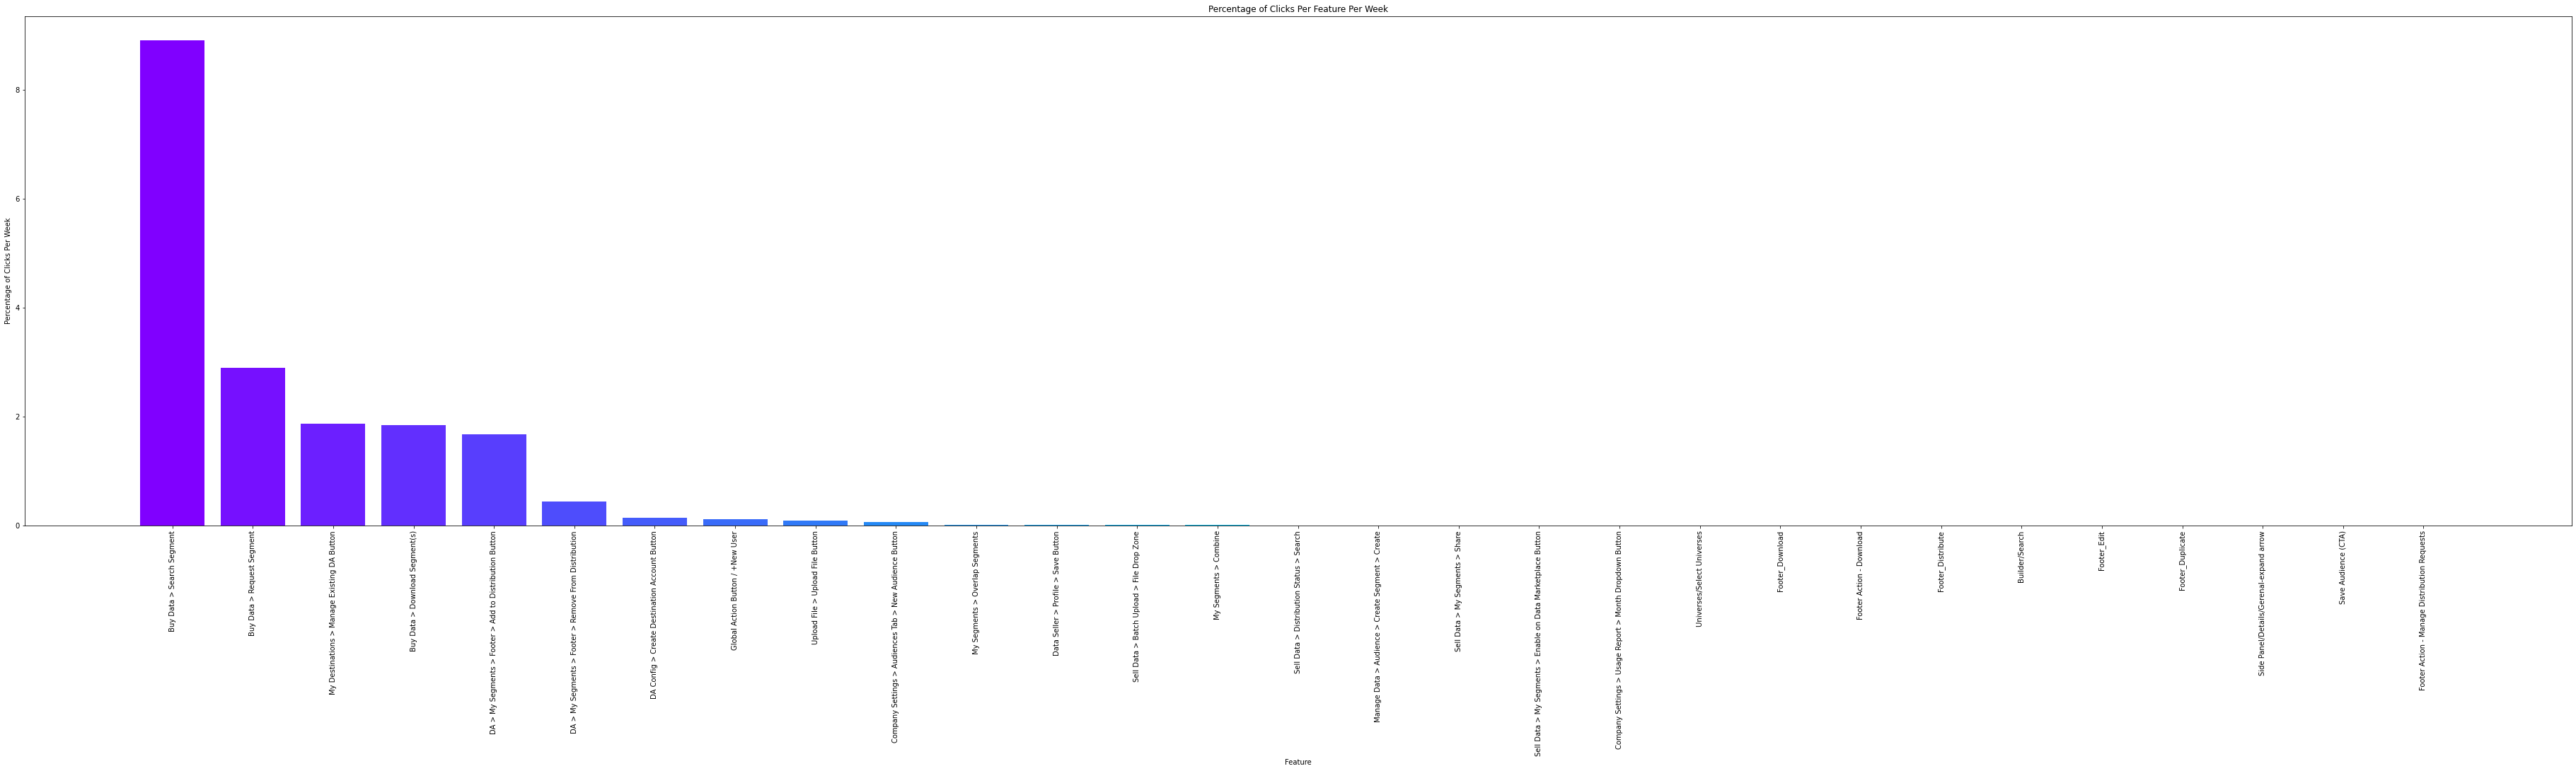

Top Pages on Left, Top Features on Right



,page
Buy Data,39.679809
Your Destination Accounts - My Segments,9.159020
Your Destination Accounts,6.959379
My Segments,3.147909
Storefront,3.117204
Audience - Segments,2.173596
DM - Storefront - Partner Detail,1.907885
My Files,1.340502
My Dashboard,1.207288
Destinations List,1.011111




PERSONA CLUSTER: 1 

NUMBER OF USERS IN CLUSTER: 1006.0 

PERCENTAGE OF USERS IN CLUSTER: 19.78 



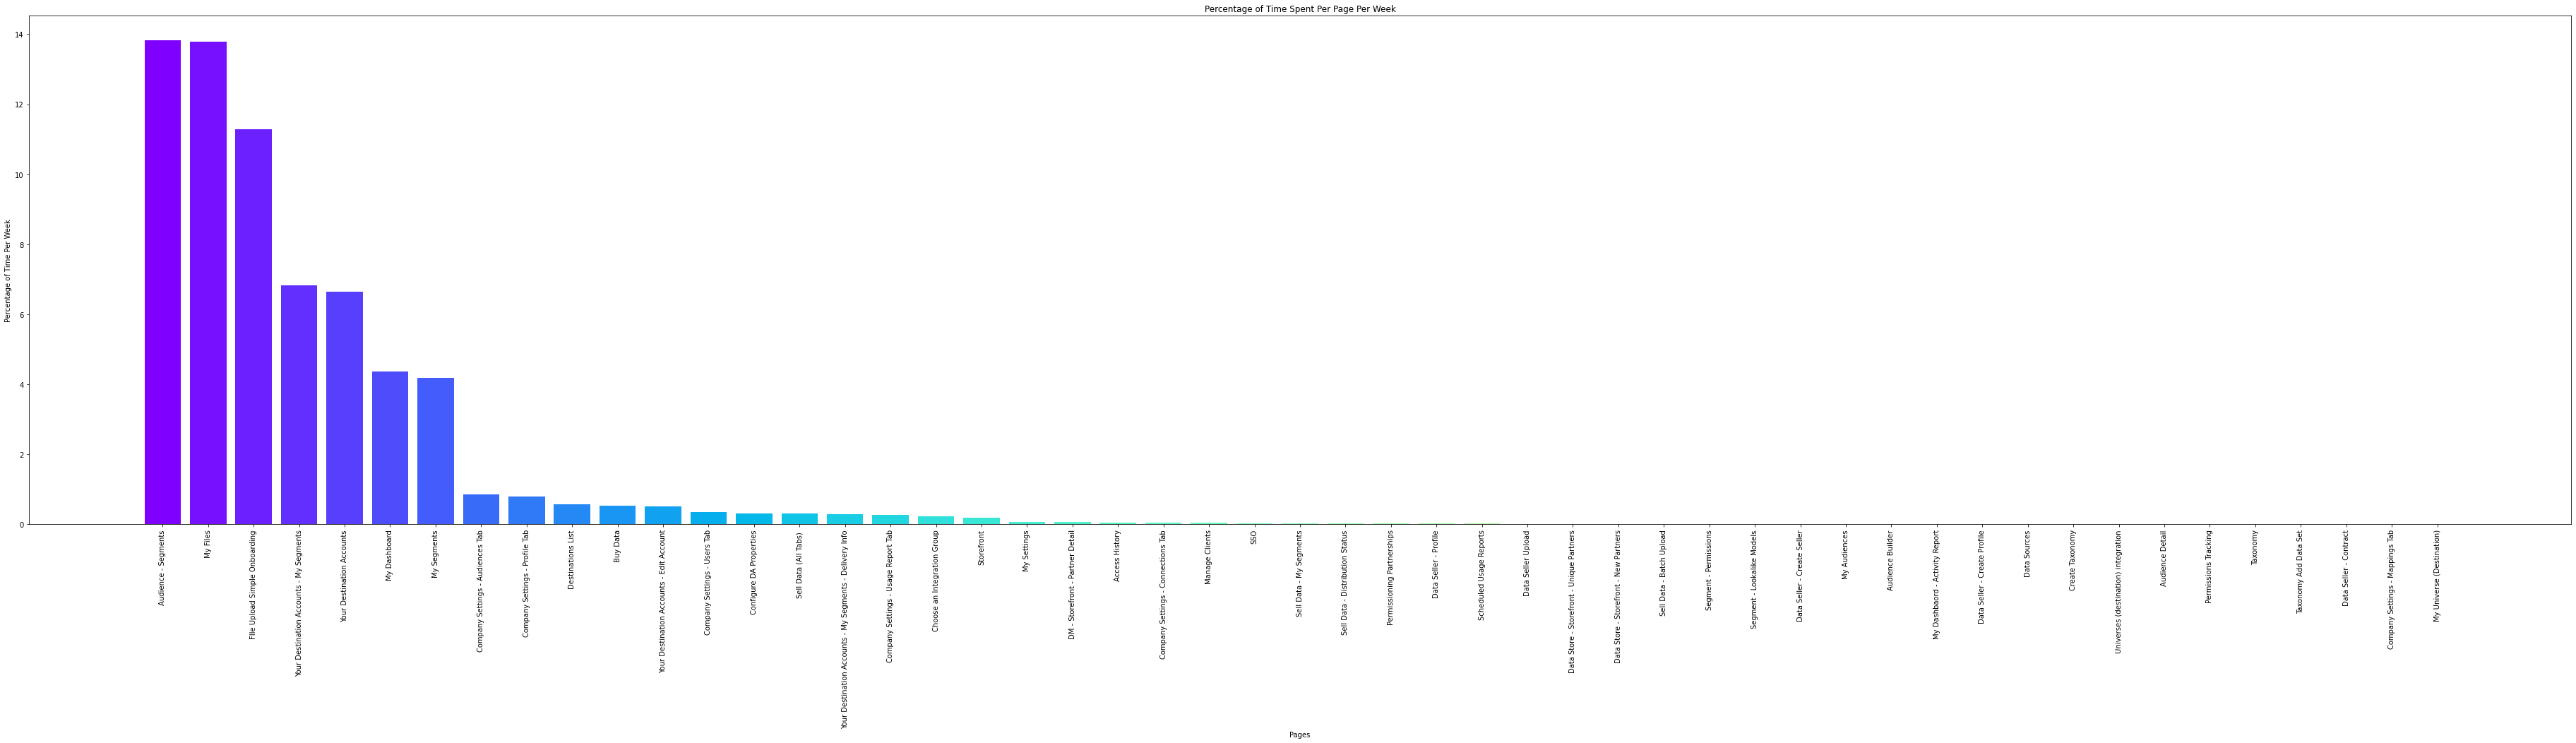

<Figure size 432x288 with 0 Axes>

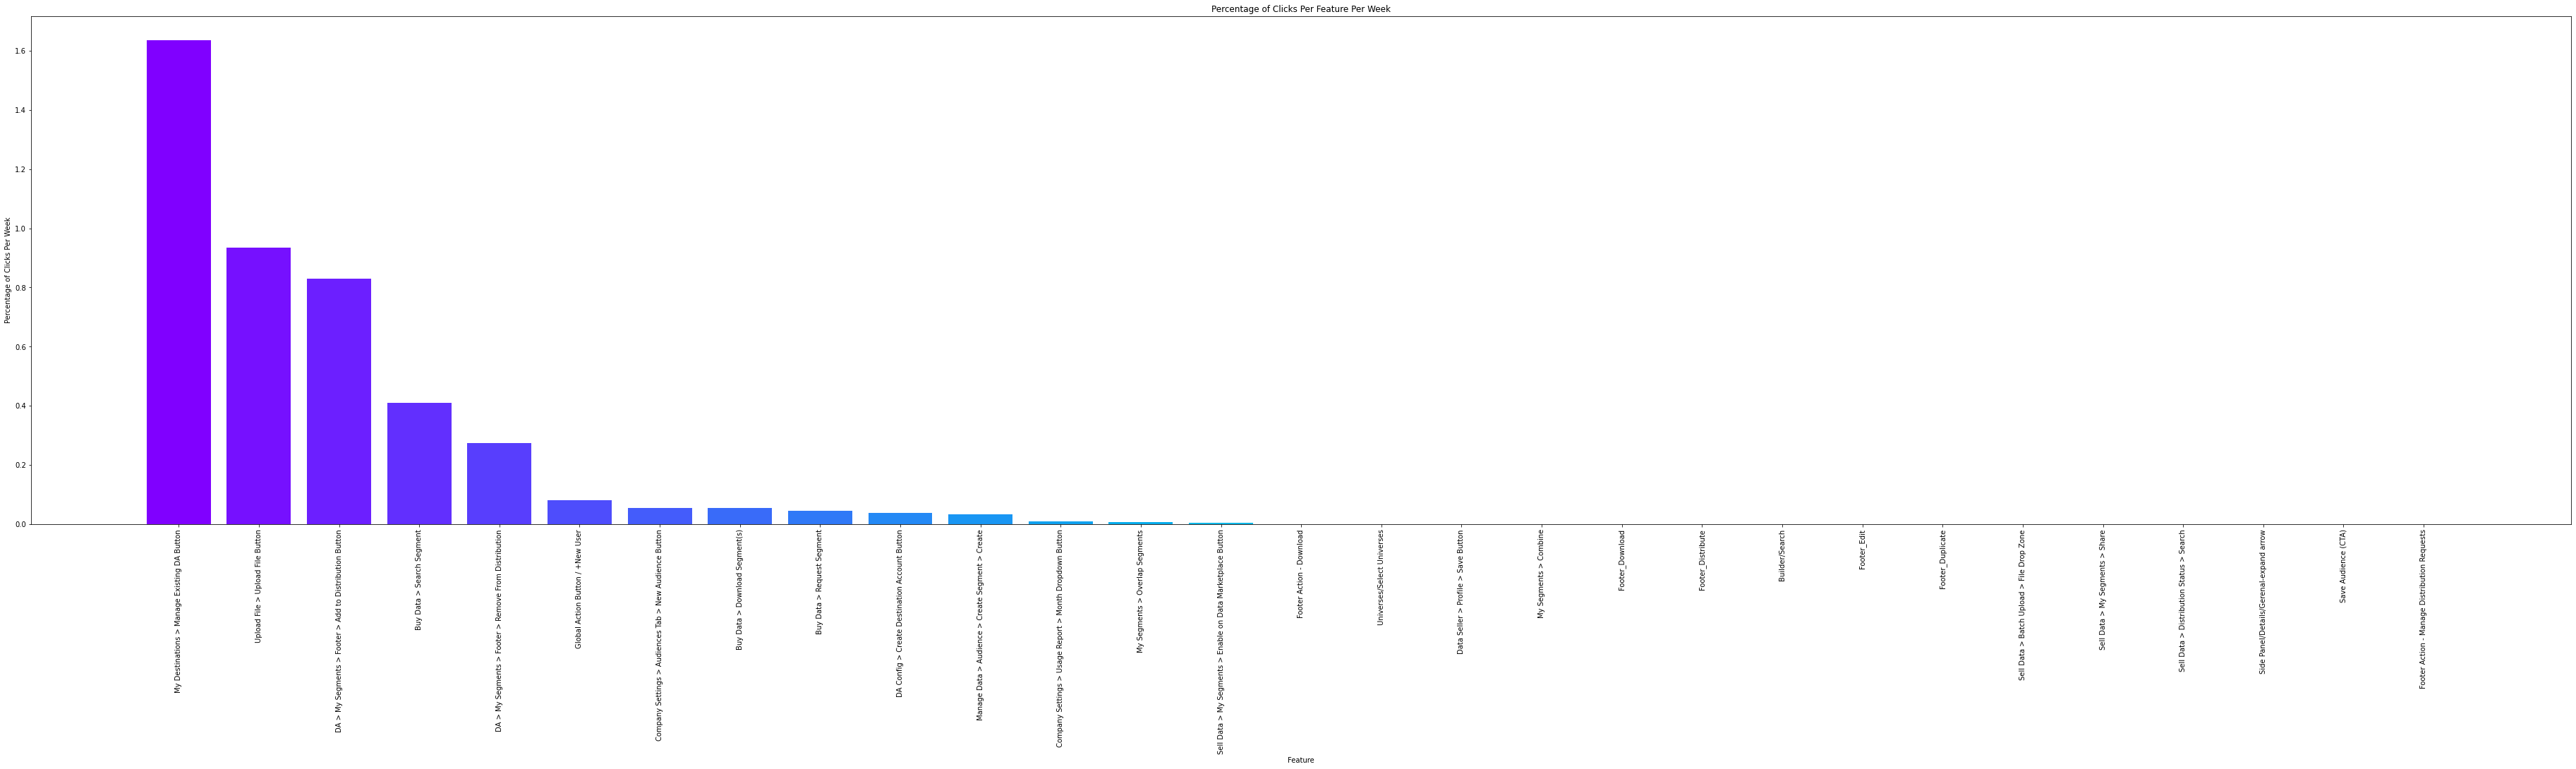

Top Pages on Left, Top Features on Right



,page
Audience - Segments,13.835984
My Files,13.794036
FIle Upload Simple Onboarding,11.288469
Your Destination Accounts - My Segments,6.823559
Your Destination Accounts,6.638668
My Dashboard,4.368191
My Segments,4.178231
Company Settings - Audiences Tab,0.854672
Company Settings - Profile Tab,0.794433
Destinations List,0.579026




PERSONA CLUSTER: 2 

NUMBER OF USERS IN CLUSTER: 778.0 

PERCENTAGE OF USERS IN CLUSTER: 15.297 



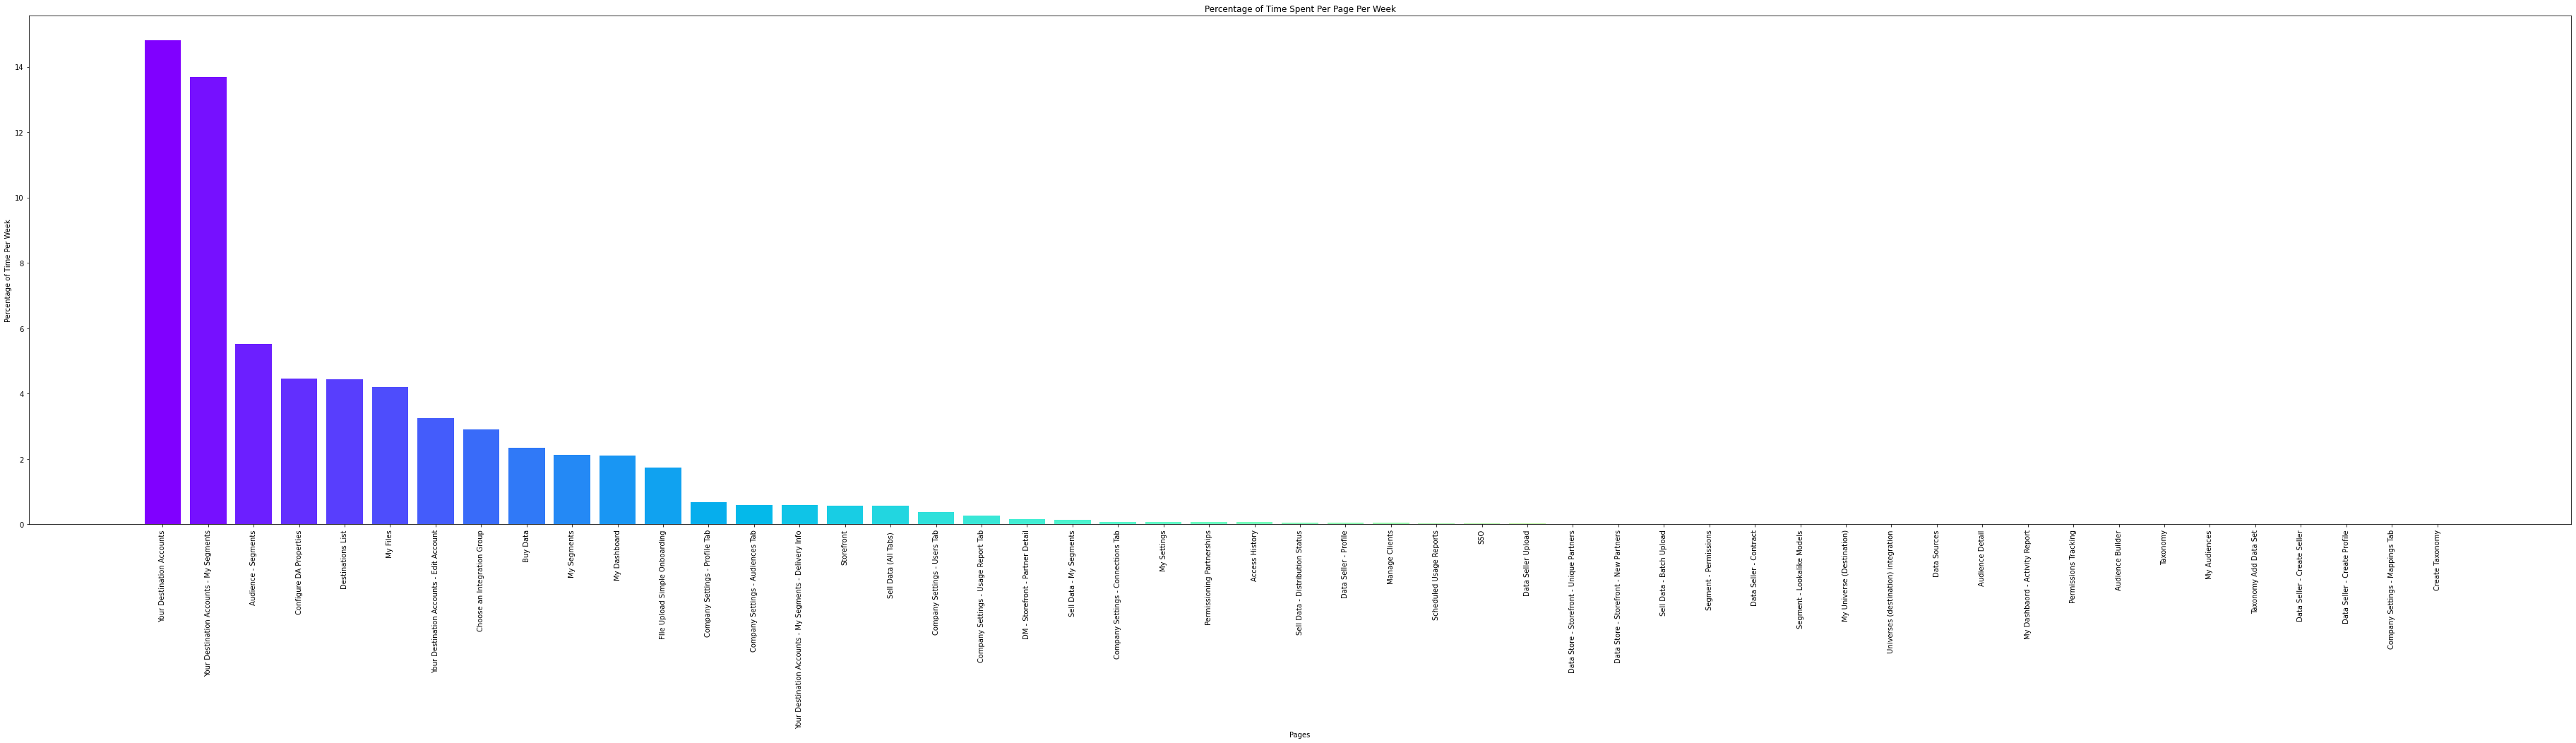

<Figure size 432x288 with 0 Axes>

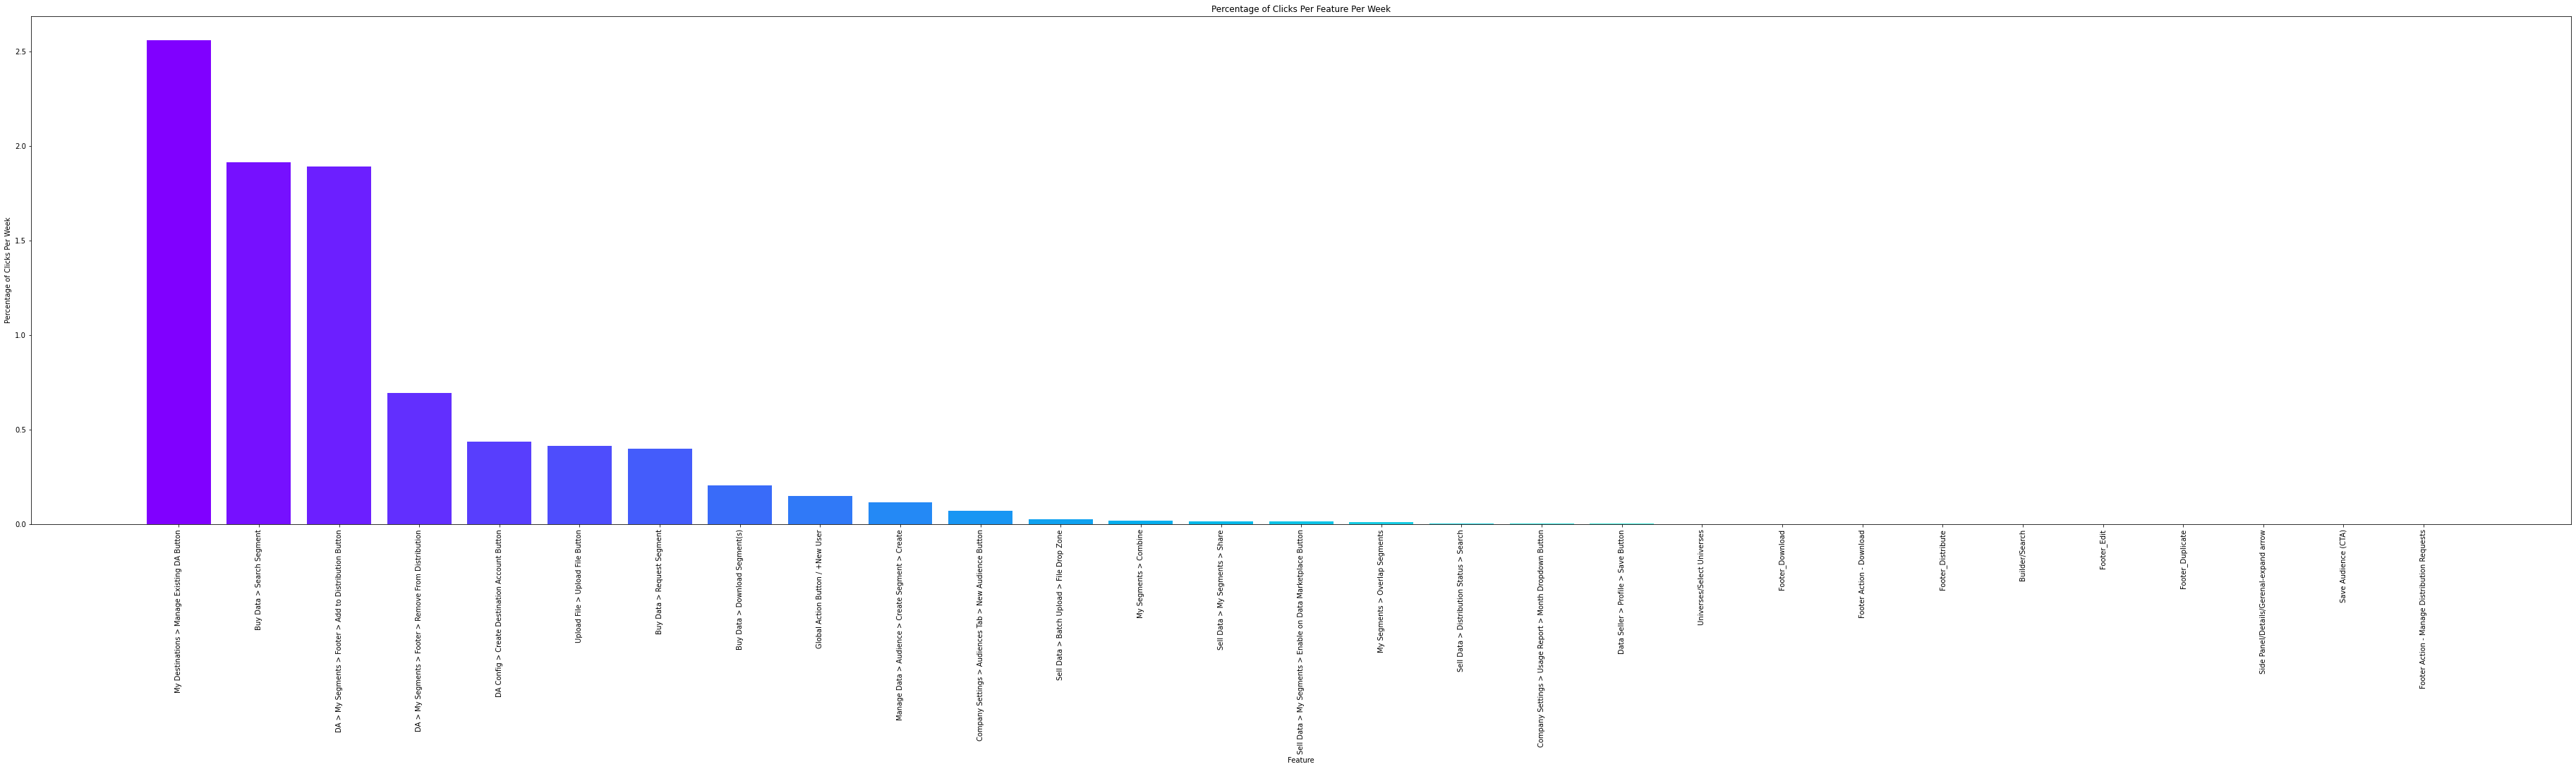

Top Pages on Left, Top Features on Right



,page
Your Destination Accounts,14.819794
Your Destination Accounts - My Segments,13.689203
Audience - Segments,5.525321
Configure DA Properties,4.455013
Destinations List,4.427121
My Files,4.193316
Your Destination Accounts - Edit Account,3.254756
Choose an Integration Group,2.894602
Buy Data,2.348586
My Segments,2.117995




PERSONA CLUSTER: 3 

NUMBER OF USERS IN CLUSTER: 1007.0 

PERCENTAGE OF USERS IN CLUSTER: 19.799 



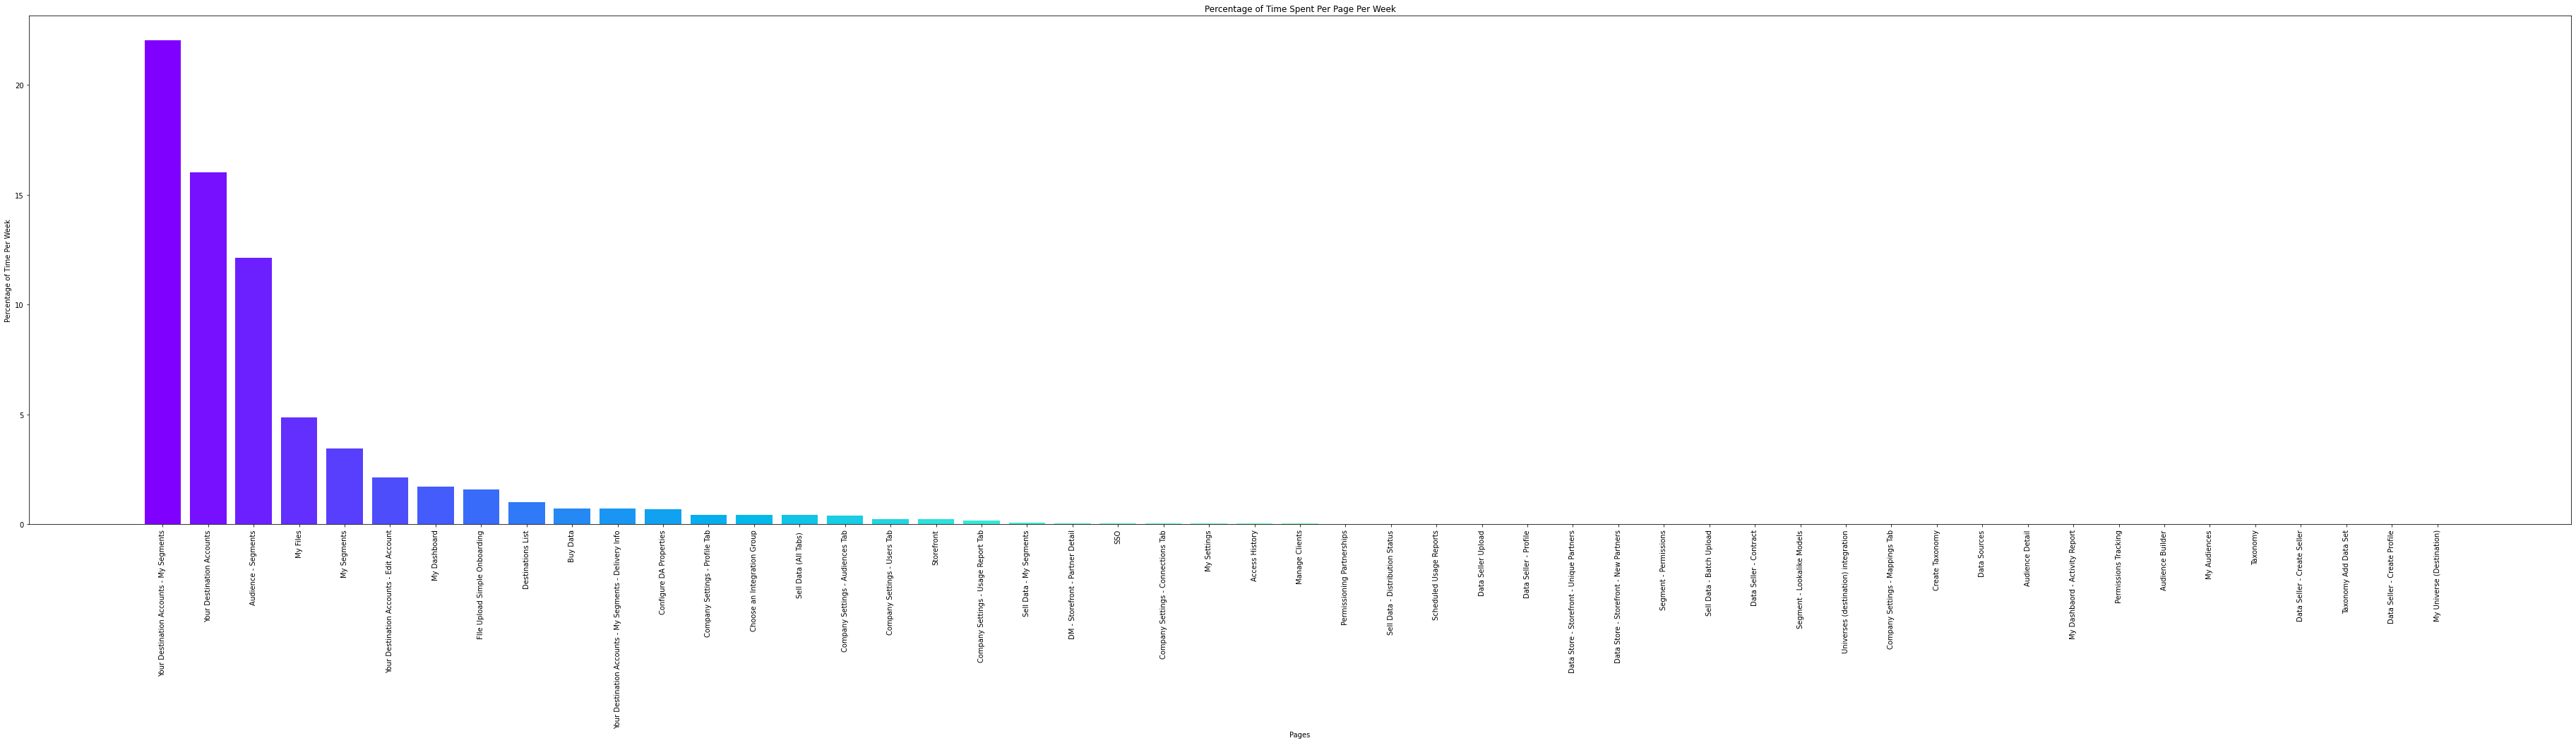

<Figure size 432x288 with 0 Axes>

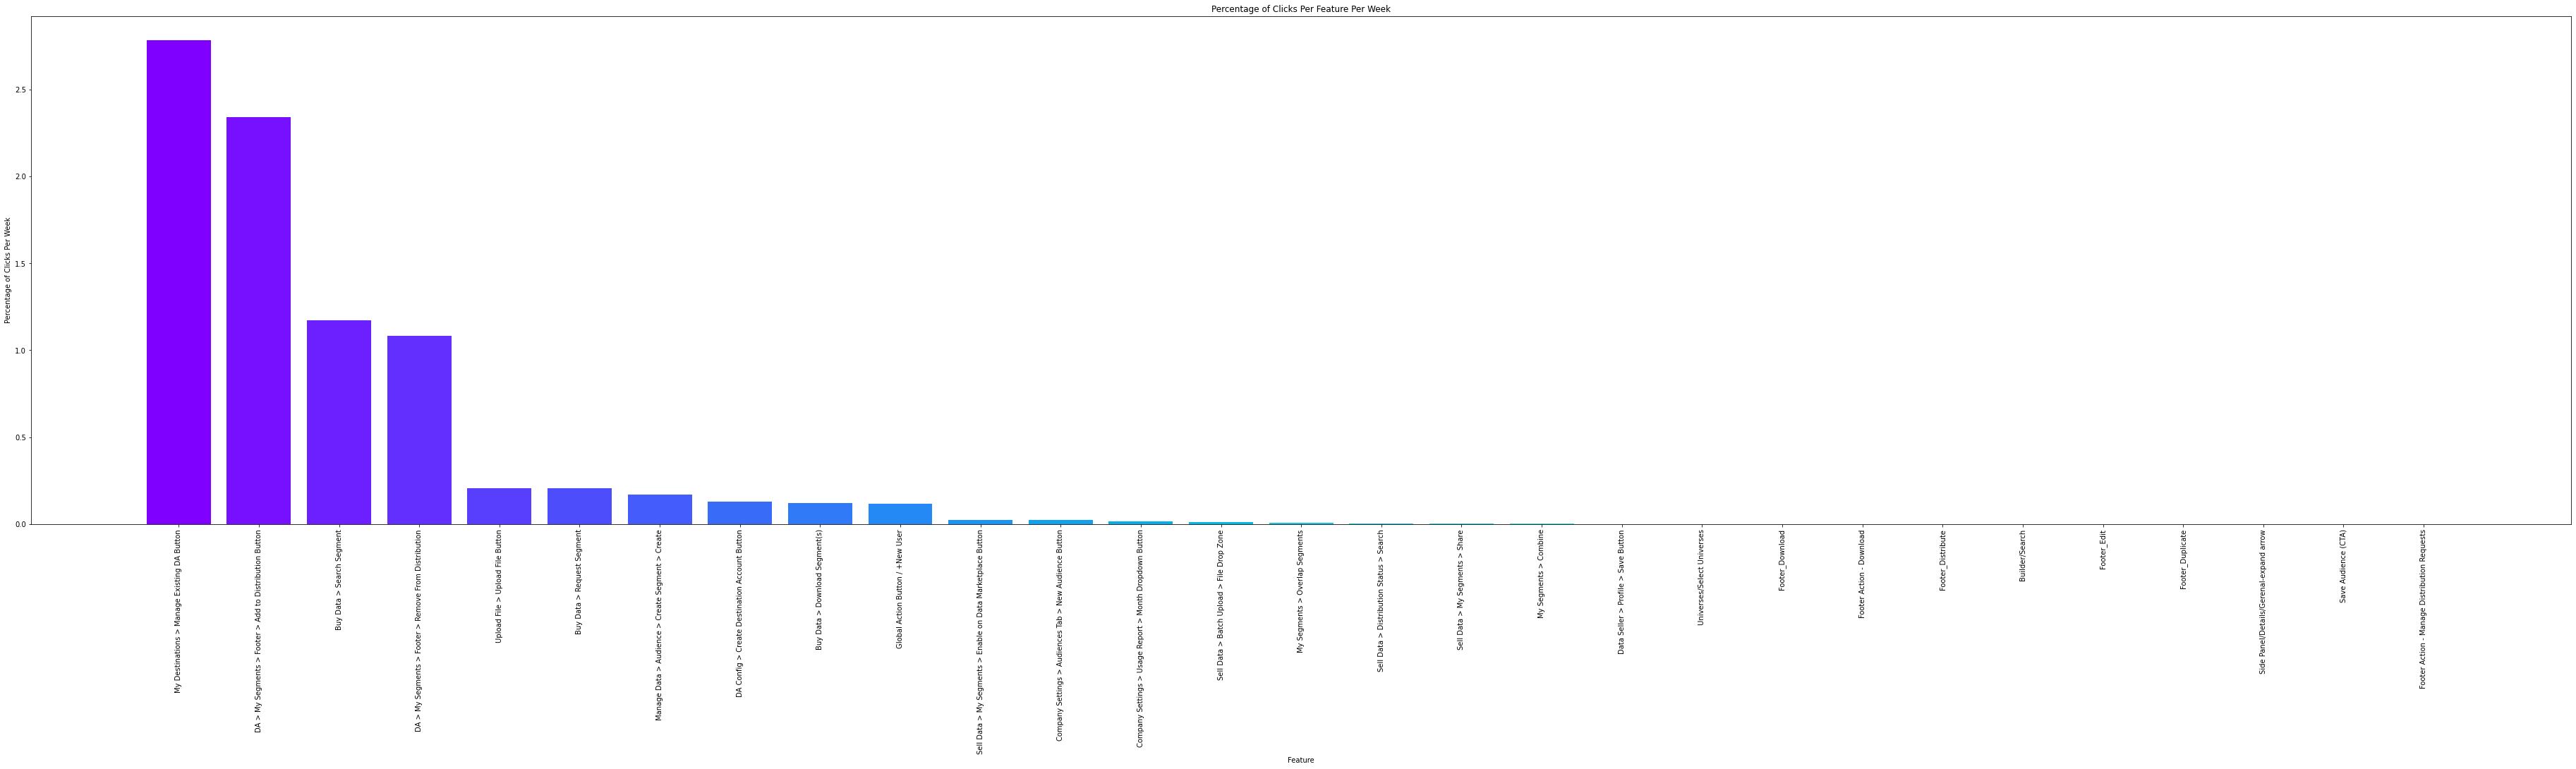

Top Pages on Left, Top Features on Right



,page
Your Destination Accounts - My Segments,22.042105
Your Destination Accounts,16.013803
Audience - Segments,12.128600
My Files,4.877855
My Segments,3.445482
Your Destination Accounts - Edit Account,2.124628
My Dashboard,1.710129
FIle Upload Simple Onboarding,1.592453
Destinations List,1.006058
Buy Data,0.726614




PERSONA CLUSTER: 4 

NUMBER OF USERS IN CLUSTER: 942.0 

PERCENTAGE OF USERS IN CLUSTER: 18.521 



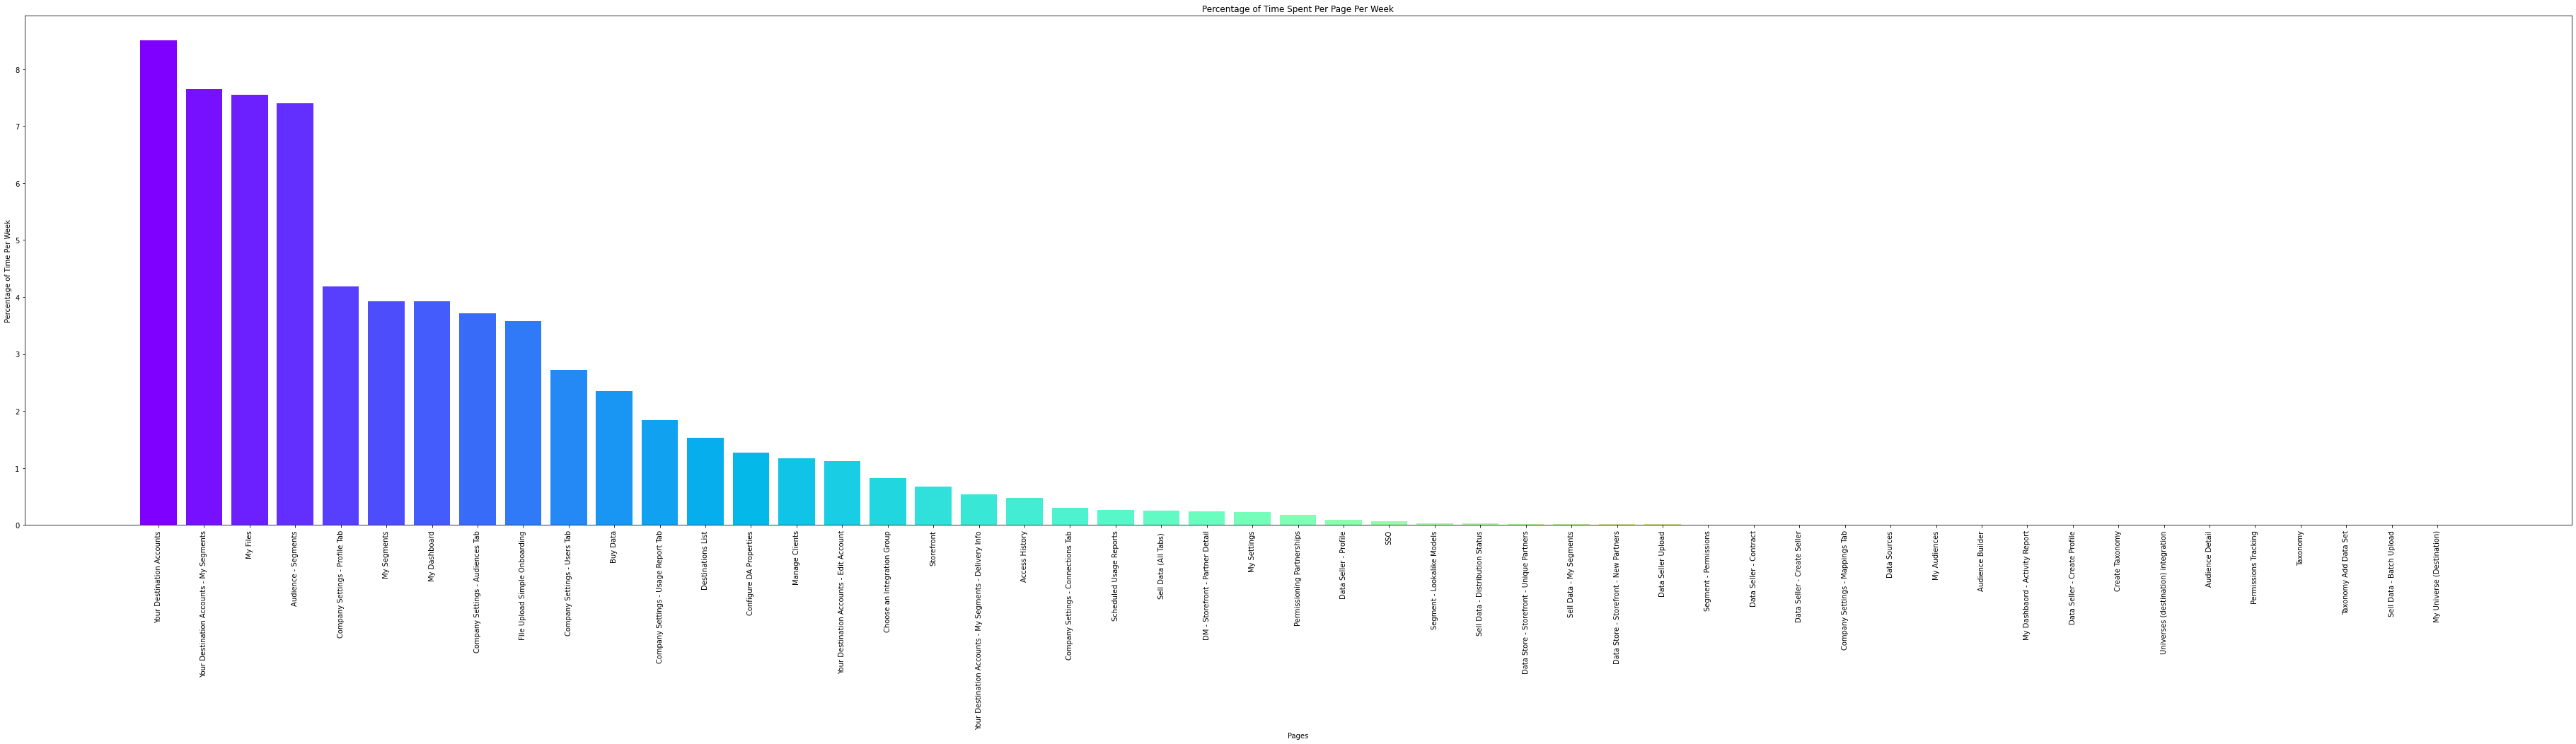

<Figure size 432x288 with 0 Axes>

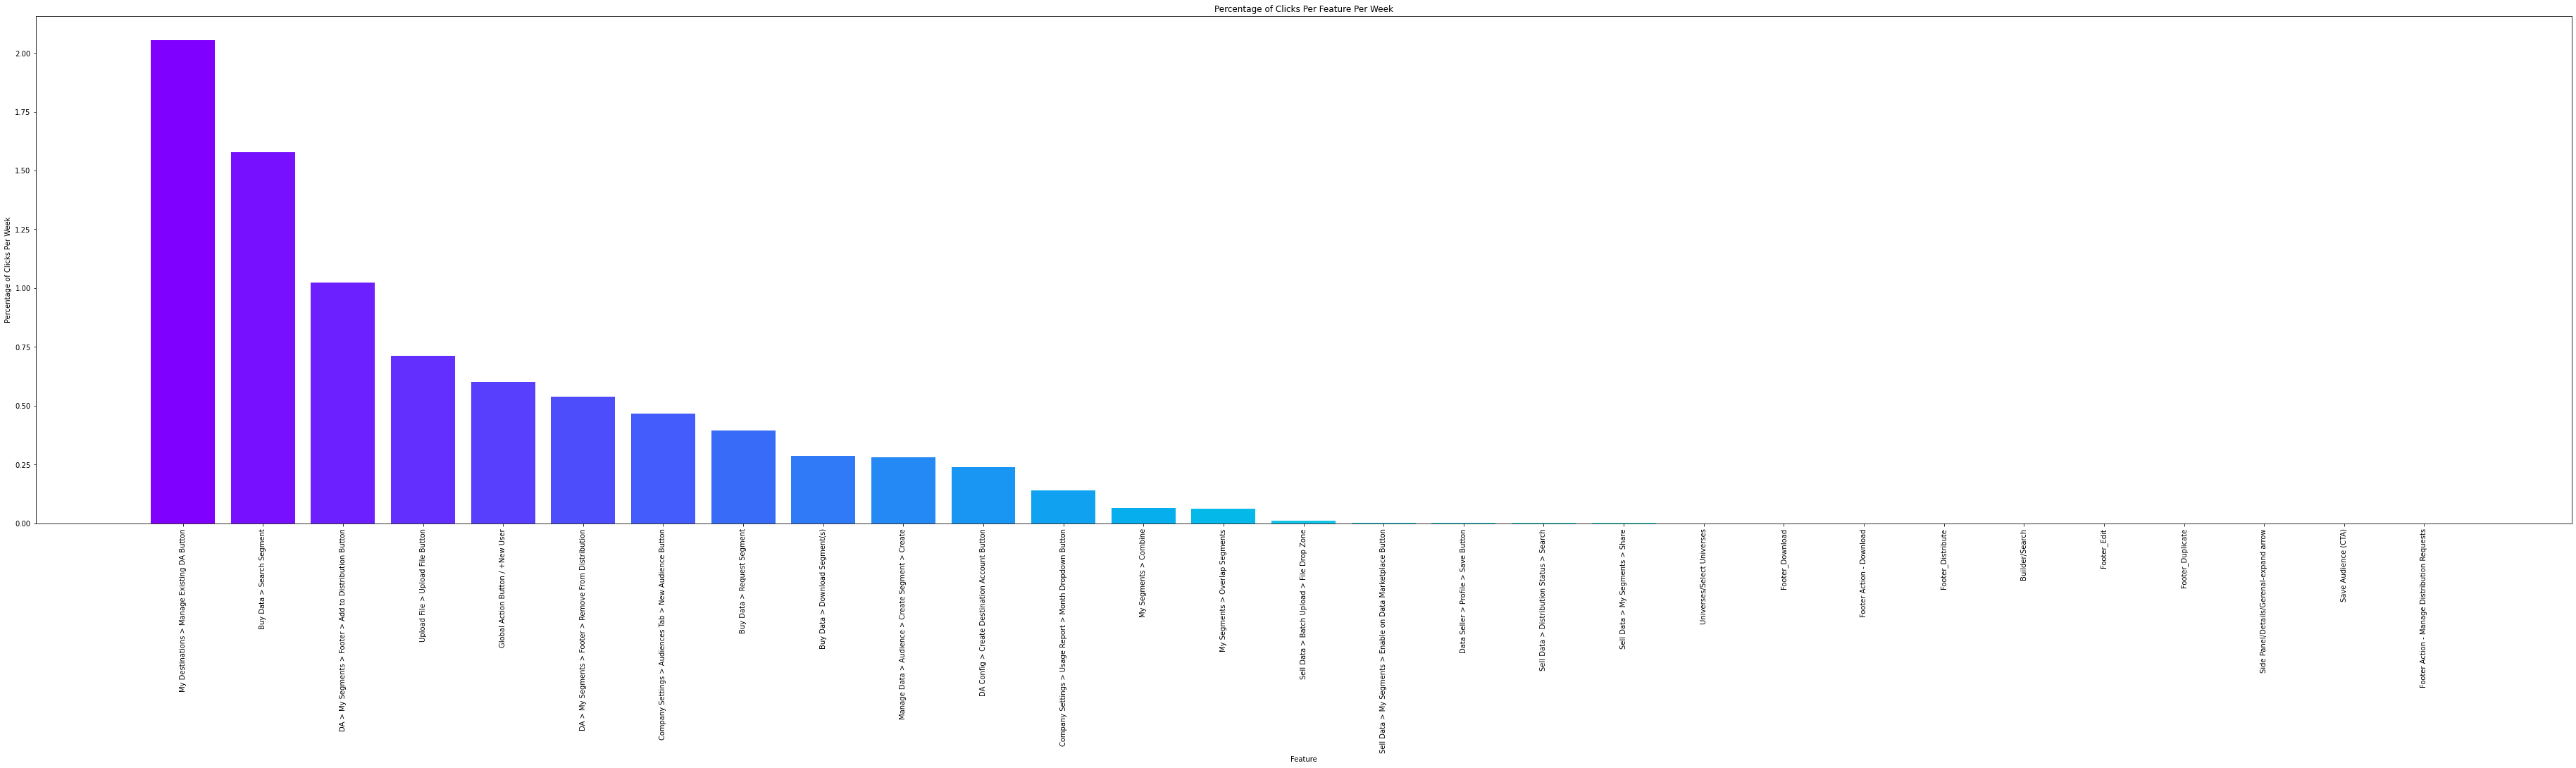

Top Pages on Left, Top Features on Right



,page
Your Destination Accounts,8.511040
Your Destination Accounts - My Segments,7.645117
My Files,7.548089
Audience - Segments,7.395966
Company Settings - Profile Tab,4.190870
My Segments,3.928981
My Dashboard,3.920488
Company Settings - Audiences Tab,3.720913
FIle Upload Simple Onboarding,3.574204
Company Settings - Users Tab,2.719002




PERSONA CLUSTER: 5 

NUMBER OF USERS IN CLUSTER: 516.0 

PERCENTAGE OF USERS IN CLUSTER: 10.145 



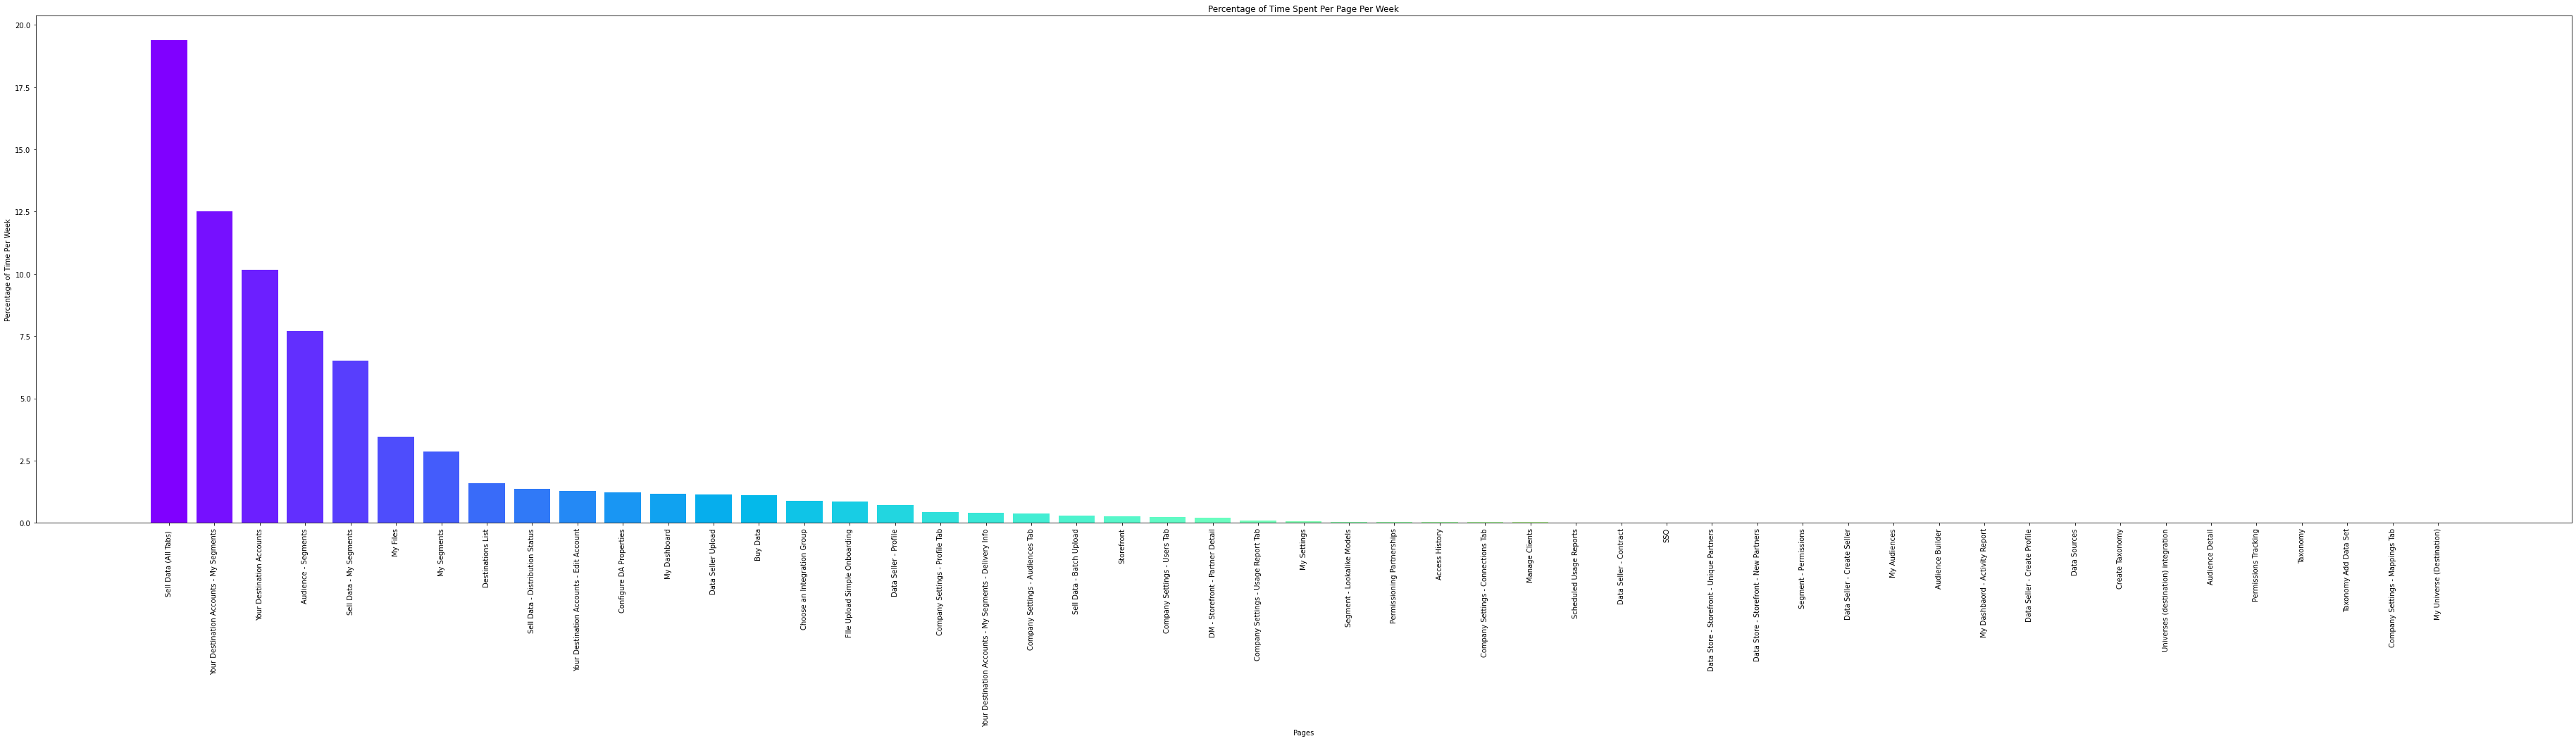

<Figure size 432x288 with 0 Axes>

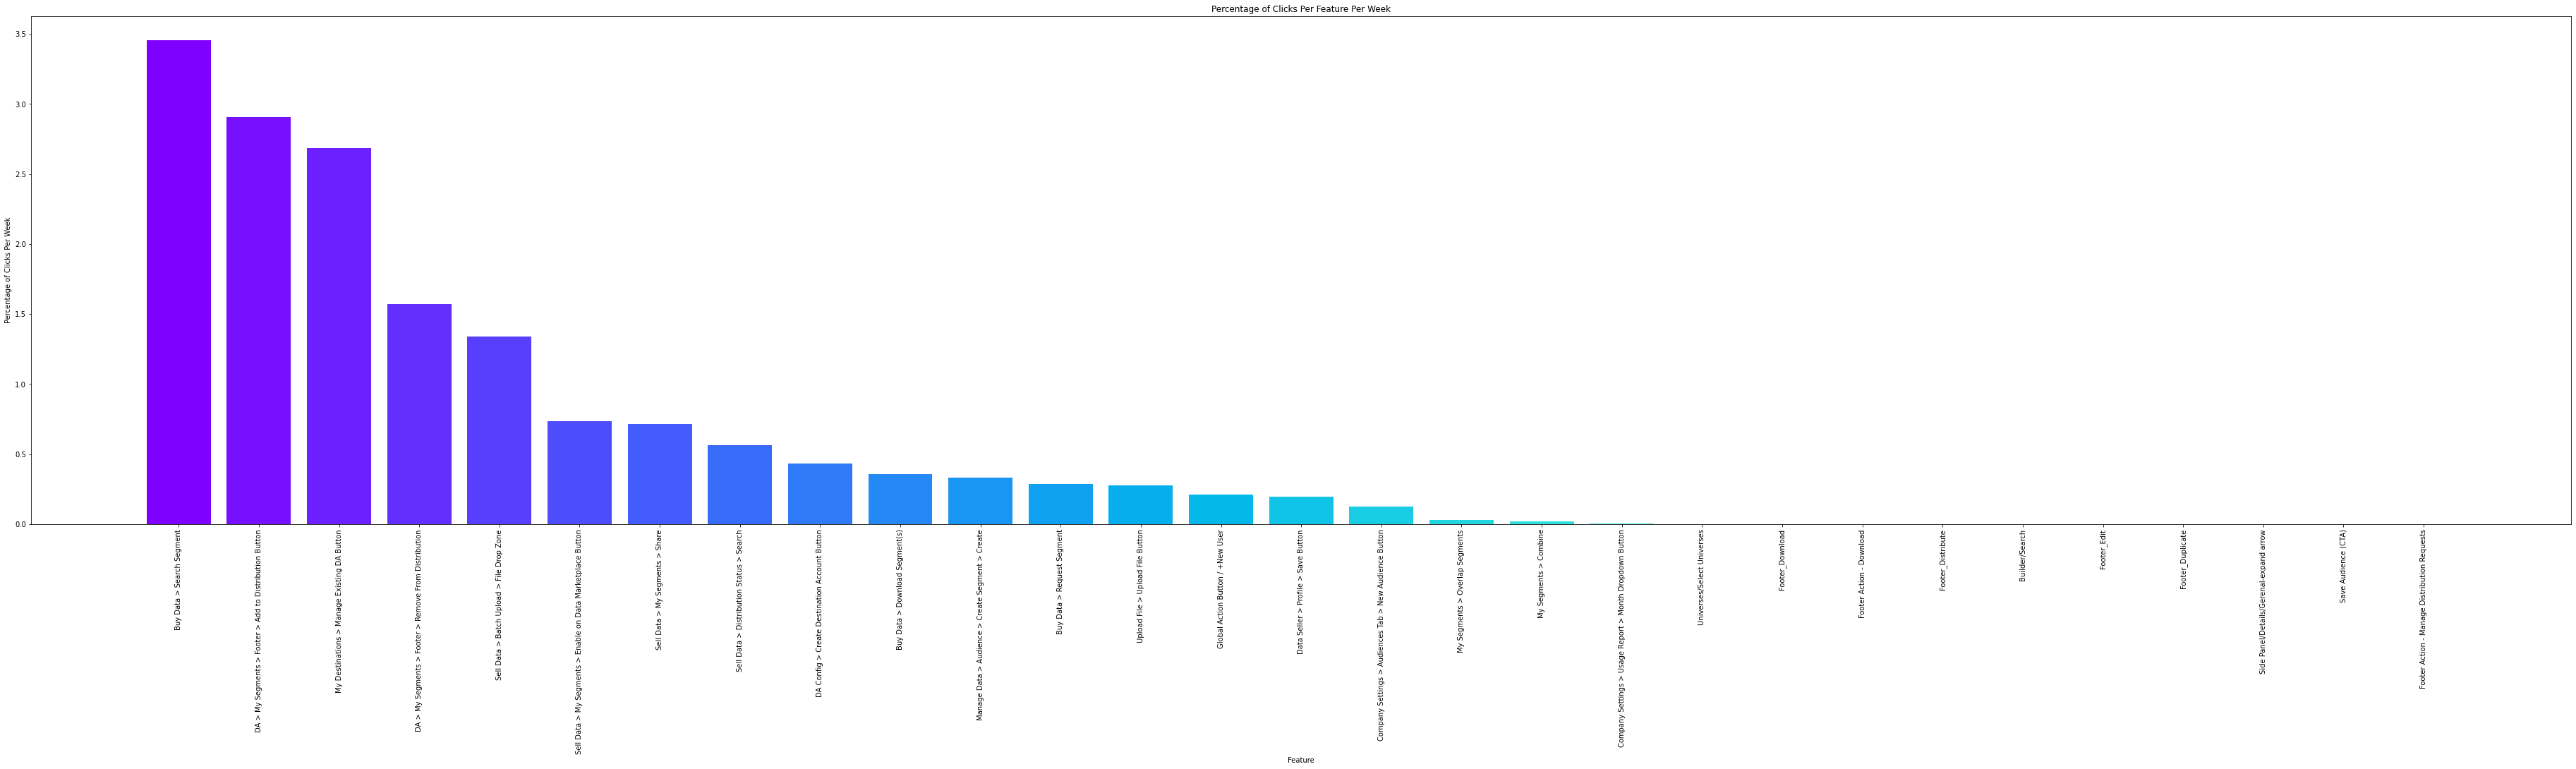

Top Pages on Left, Top Features on Right



,page
Sell Data (All Tabs),19.395930
Your Destination Accounts - My Segments,12.504845
Your Destination Accounts,10.151163
Audience - Segments,7.709496
Sell Data - My Segments,6.503295
My Files,3.460465
My Segments,2.856589
Destinations List,1.592442
Sell Data - Distribution Status,1.378295
Your Destination Accounts - Edit Account,1.280233


In [ ]:
cluster_means_and_plots_both(kmeans_summary_3, 10, 0) 
cluster_means_and_plots_both(kmeans_summary_3, 10, 1) 
cluster_means_and_plots_both(kmeans_summary_3, 10, 2) 
cluster_means_and_plots_both(kmeans_summary_3, 10, 3) 
cluster_means_and_plots_both(kmeans_summary_3, 10, 4)
cluster_means_and_plots_both(kmeans_summary_3, 10, 5)

##Iteration 4: HDBScan, UMAP, Weekly Percentage Data
By seeking to analyze and address the questions that arose from the prior iteration, we realized that we were dimming certain signals by aggregating the data to be per day since many of our processes take 1- 3 business days and a substantial number of users visit our platform on a weekly basis rather than a daily basis. 

With this iteration, we changed our preprocessing to create percentage data based on weekly interactions (i.e. user X spends 50% of time per week on page Y). We also decided to use HDBScan, a hierarchical density based clustering method that detects the number of clusters since it would be better suited for our dataset and not require us to bias our persona generation by hardcoding the number of clusters. KMeans makes certain assumptions about the qualities of the clusters that our visualizations and analytics showed to not be true, such as the data being “round” or spherical, equally sized, equally dense, most dense in the center of the sphere, and not contaminated by noise/outliers. Like the previous iteration, we removed our already identified cluster of TV users from the dataset. 

With the first pass, we generated four distinct clusters. The largest cluster, which we named “Generalist,” seemed to represent users of our core offering and user experience, which seemed to not have nuances loud enough to warrant a separate cluster within the larger dataset. The other three clusters aligned with those that were already identified from user interviews but were now backed by data and could be further examined. 

We then ran a second pass on just the generalist cluster with the same methodology and found that a sub persona had a strong enough signal to be clustered when just looking at this sample set. This persona was then added to our list, resulting in six total personas. 

In [ ]:
#Combining the average percentage data on the pages and features
%%bigquery --project uxr-design-us-dev percentage_per_week_df
SELECT * EXCEPT(_email)
FROM `mixed_methods_clustering.ave_percentage_of_clicks_per_feature_clustering_dataset_create_segment_update` f
INNER JOIN `mixed_methods_clustering.ave_percentage_of_time_on_page_clustering_dataset_create_segment_update` p
ON f._visitor_id = p._visitor_id

In [ ]:
#Since the data is combined, drop the duplicate visitor_id column
percentage_per_week_df = percentage_per_week_df.drop(columns= ["_visitor_id_1"])

#The dataset has columns that were incorrectly formatted- adjust here
percentage_per_week_df = percentage_per_week_df.rename(columns={"_visitor_id":"visitor_id"})

In [ ]:
# Scaling the data to bring all the attributes to a comparable level
scaler = StandardScaler()
X_scaled = scaler.fit_transform(percentage_per_week_df[ids])

# Normalizing the data so that the data
# approximately follows a Gaussian distribution
X_normalized = normalize(X_scaled)

# Converting the numpy array into a pandas DataFrame
X_normalized = pd.DataFrame(X_normalized)

# Renaming the columns
X_normalized.columns = X[ids].columns

Percent Clustered: 89


PERSONA CLUSTER: 0 

NUMBER OF USERS IN CLUSTER: 836.0 

PERCENTAGE OF USERS IN CLUSTER: 13.182 



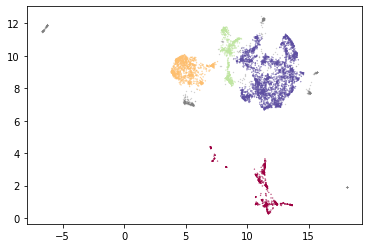

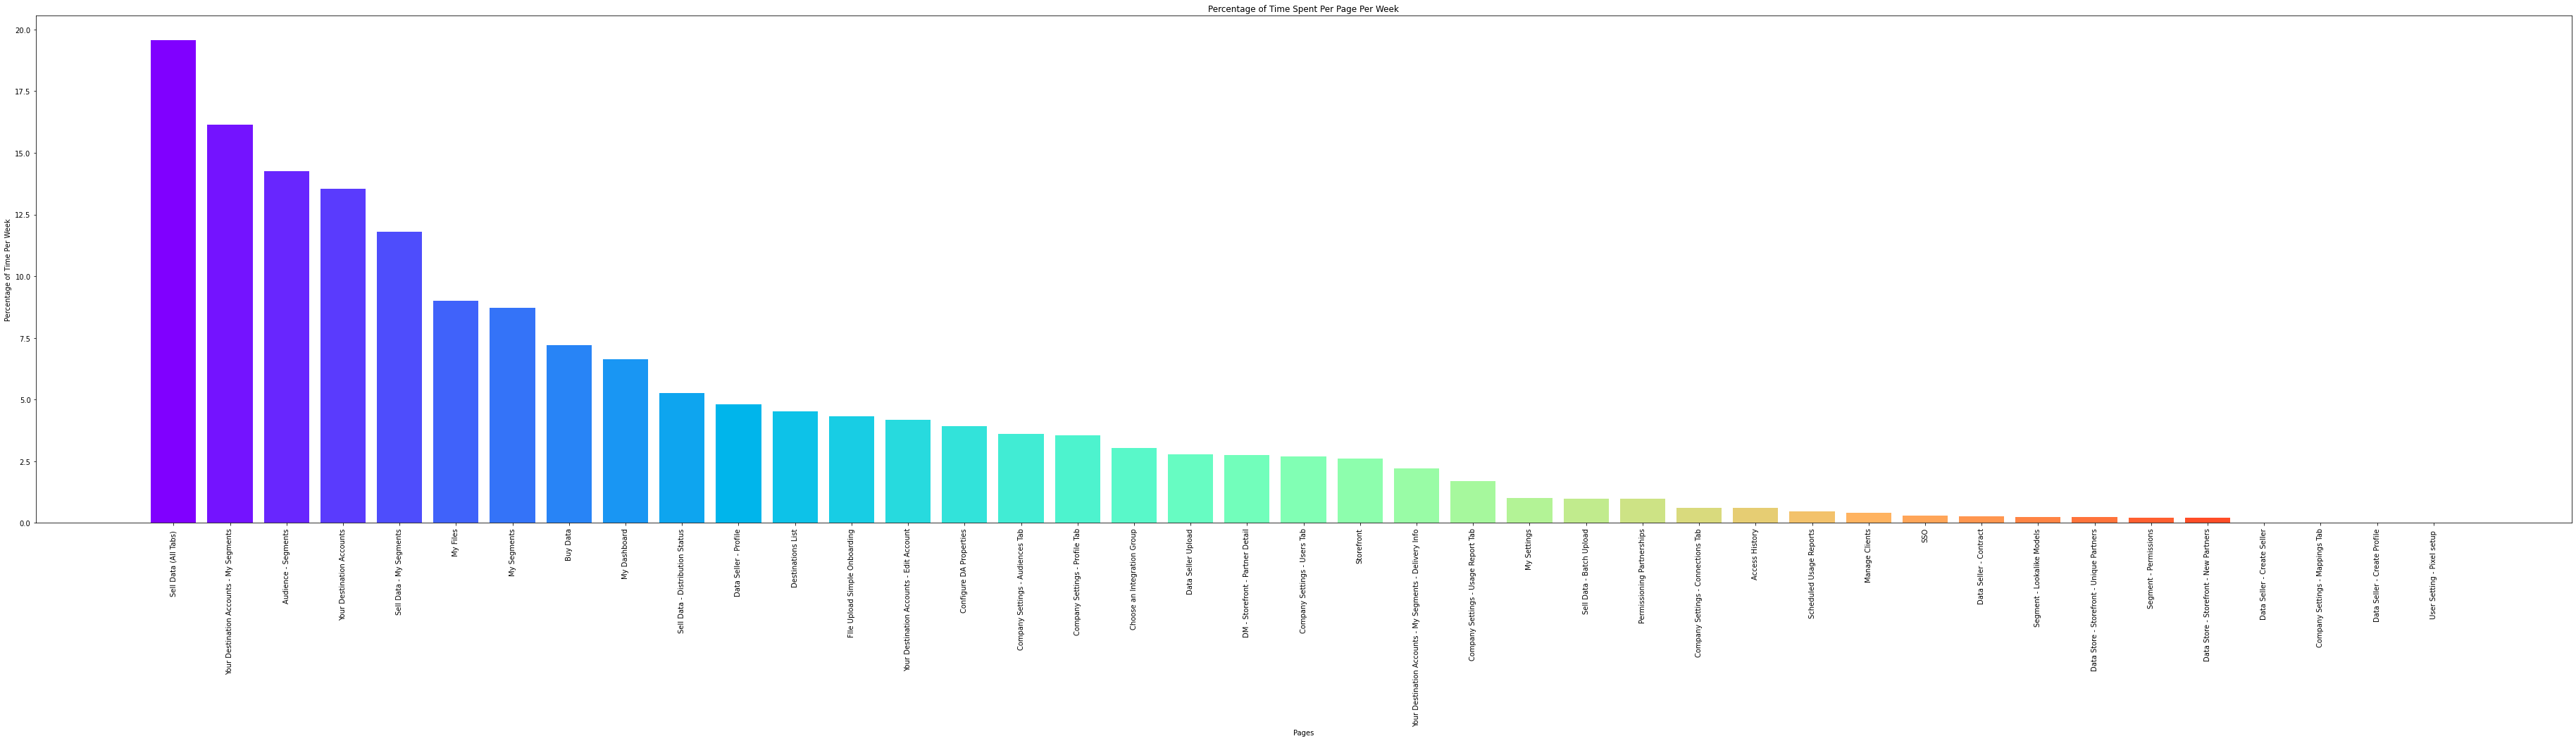

<Figure size 432x288 with 0 Axes>

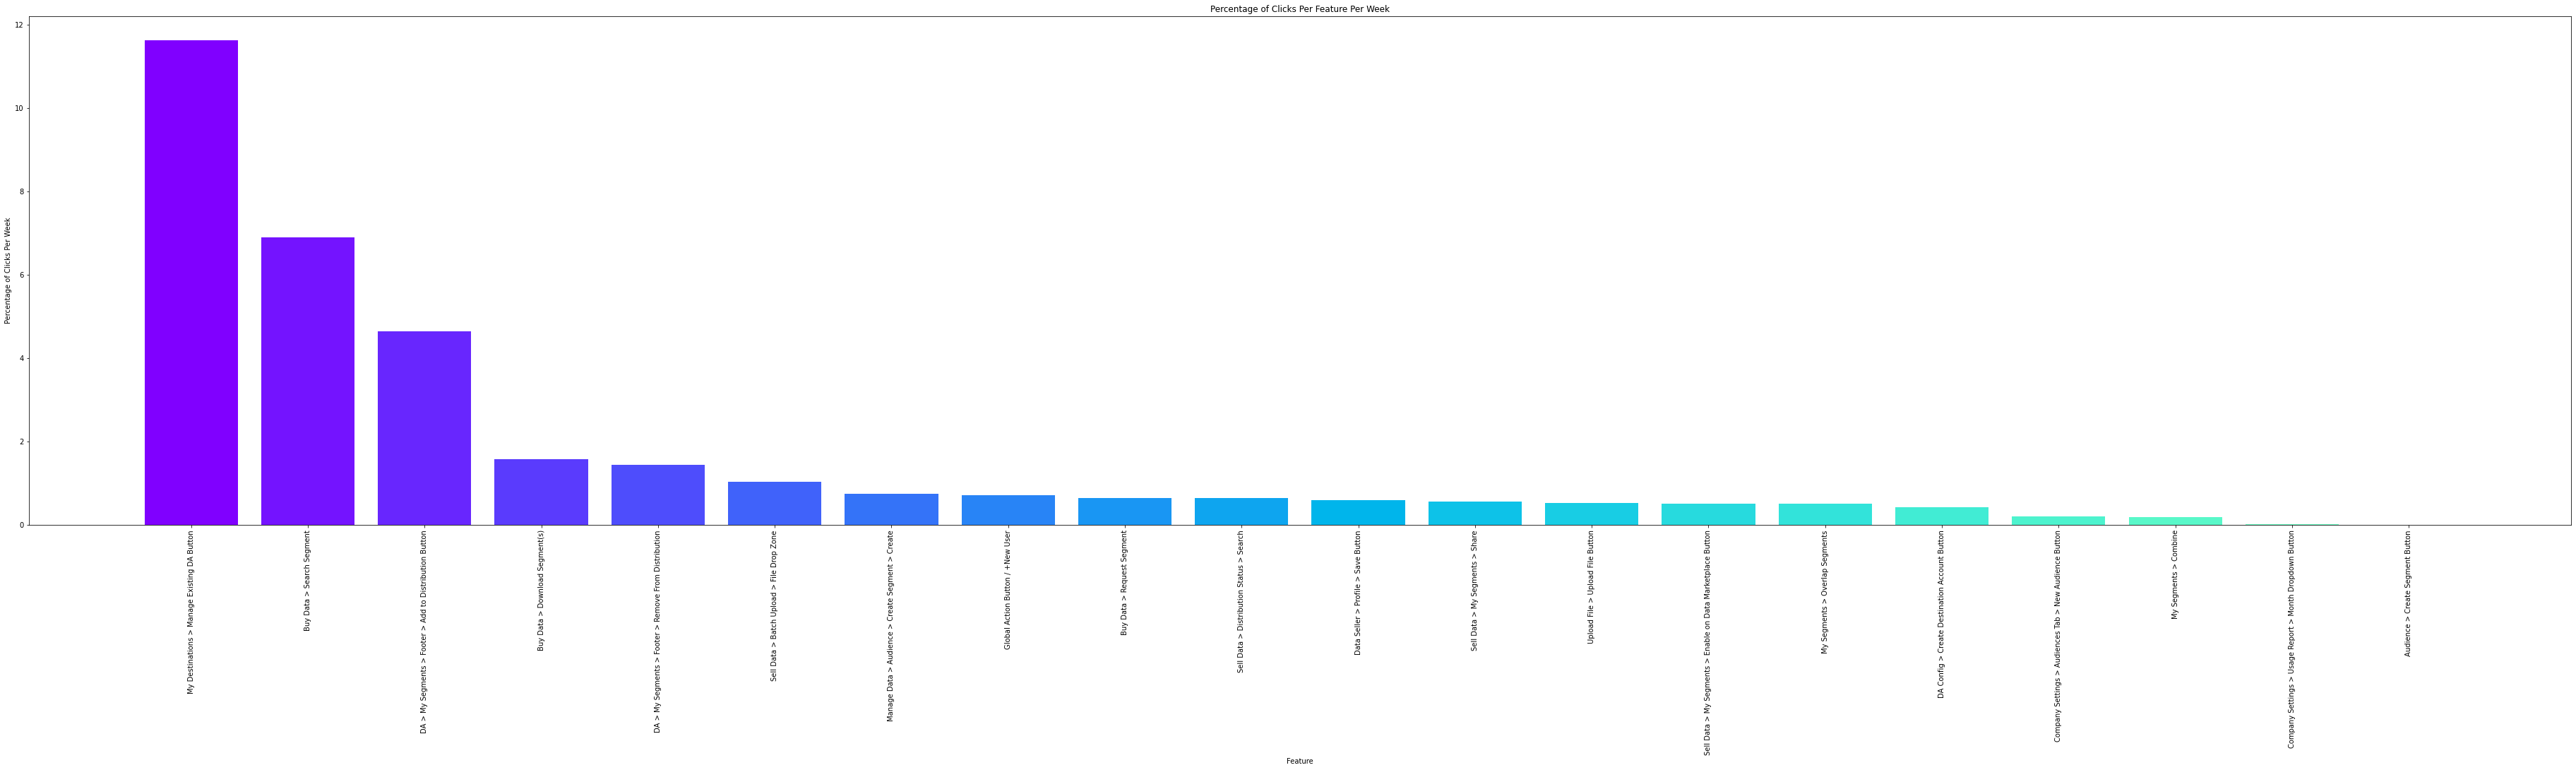

Top Pages on Left, Top Features on Right



,page
name,
Sell Data (All Tabs),19.581599
Your Destination Accounts - My Segments,16.130578
Audience - Segments,14.269533
Your Destination Accounts,13.545687
Sell Data - My Segments,11.797409
My Files,9.006896
My Segments,8.709249
Buy Data,7.203044
My Dashboard,6.629839




PERSONA CLUSTER: 1 

NUMBER OF USERS IN CLUSTER: 1107.0 

PERCENTAGE OF USERS IN CLUSTER: 17.455 



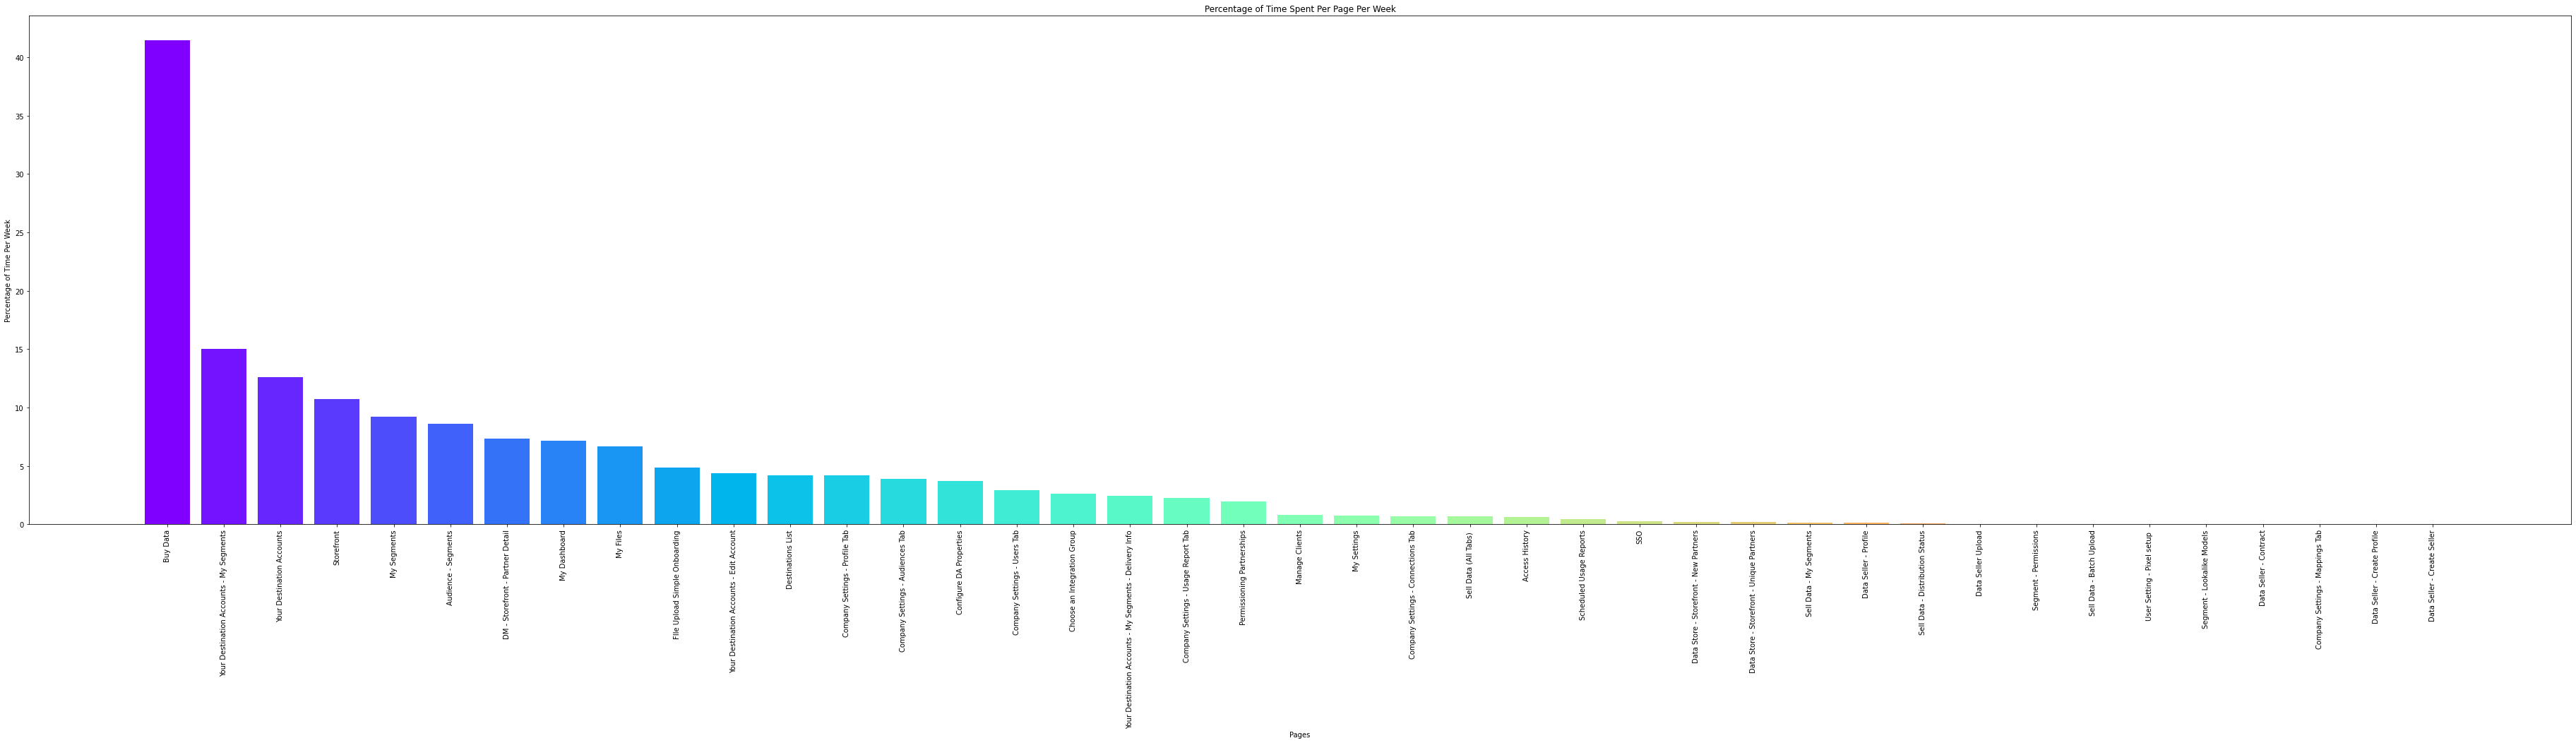

<Figure size 432x288 with 0 Axes>

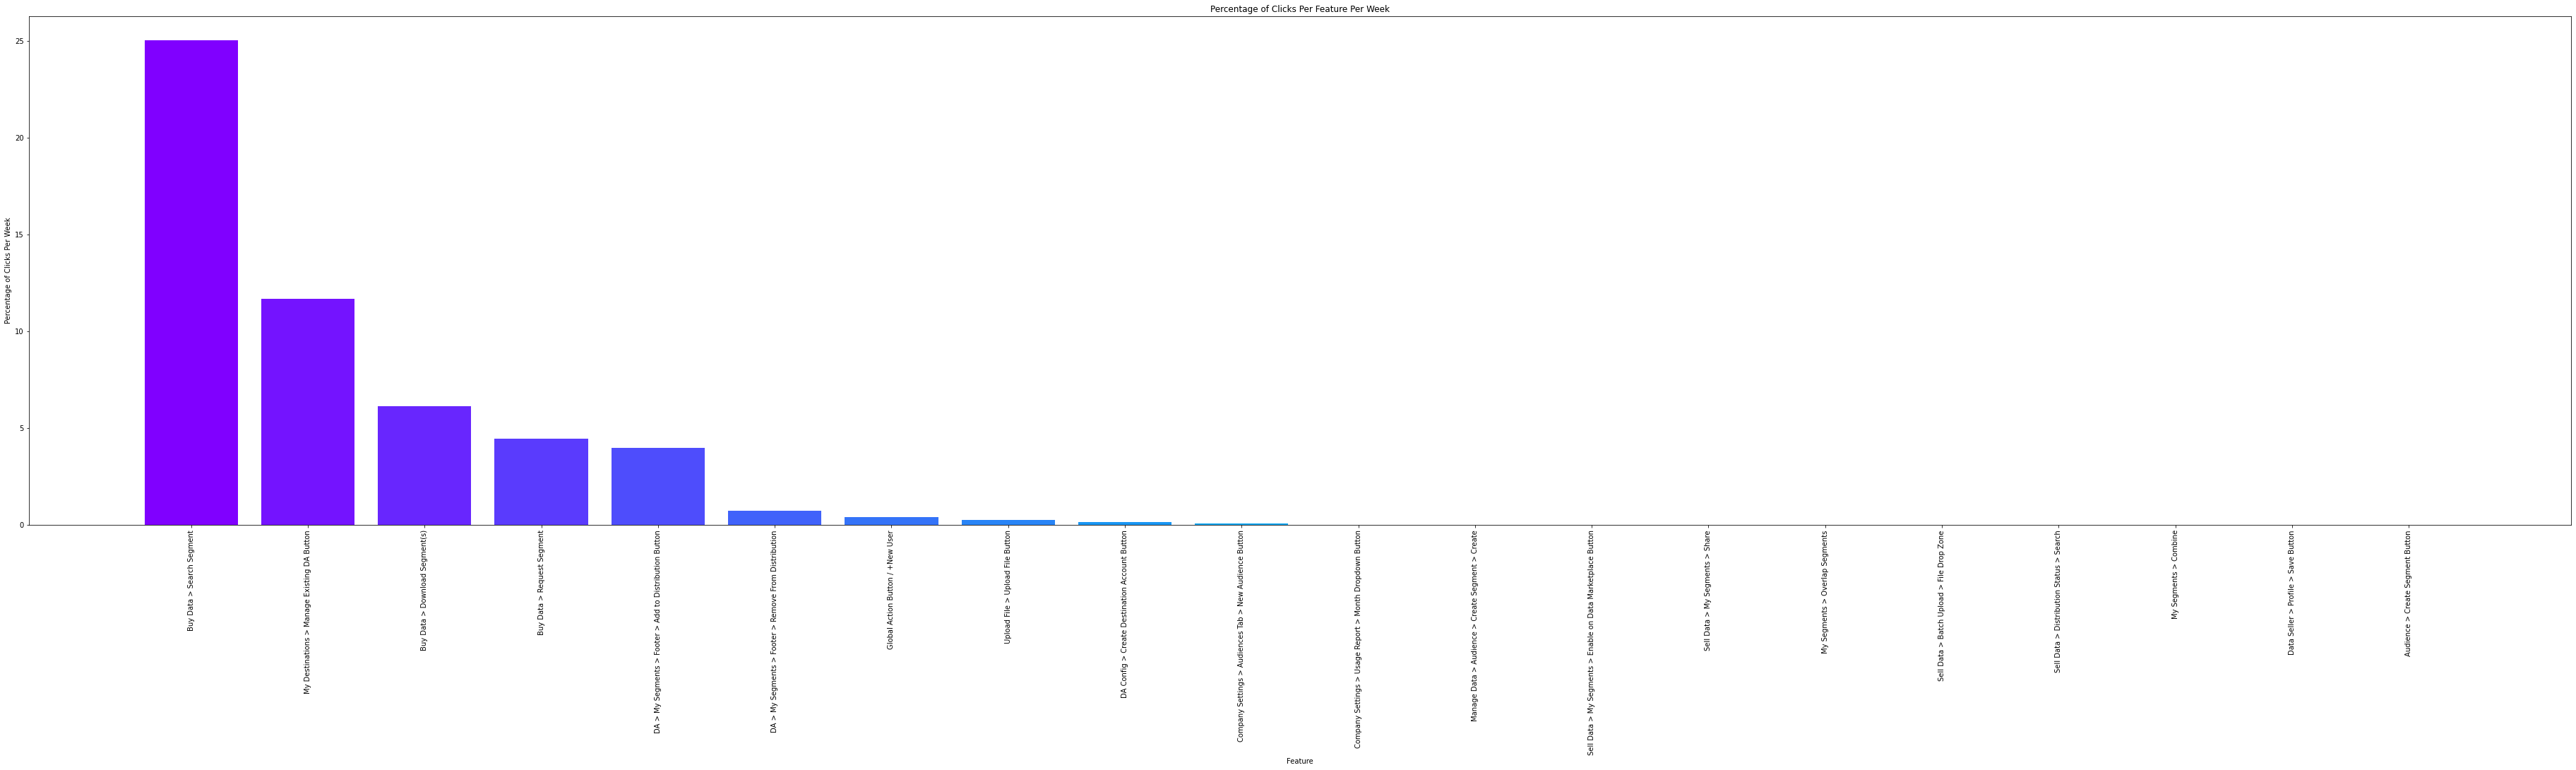

Top Pages on Left, Top Features on Right



,page
name,
Buy Data,41.474597
Your Destination Accounts - My Segments,15.024497
Your Destination Accounts,12.579695
Storefront,10.752743
My Segments,9.219443
Audience - Segments,8.635319
DM - Storefront - Partner Detail,7.344499
My Dashboard,7.173670
My Files,6.690887




PERSONA CLUSTER: 2 

NUMBER OF USERS IN CLUSTER: 707.0 

PERCENTAGE OF USERS IN CLUSTER: 11.148 



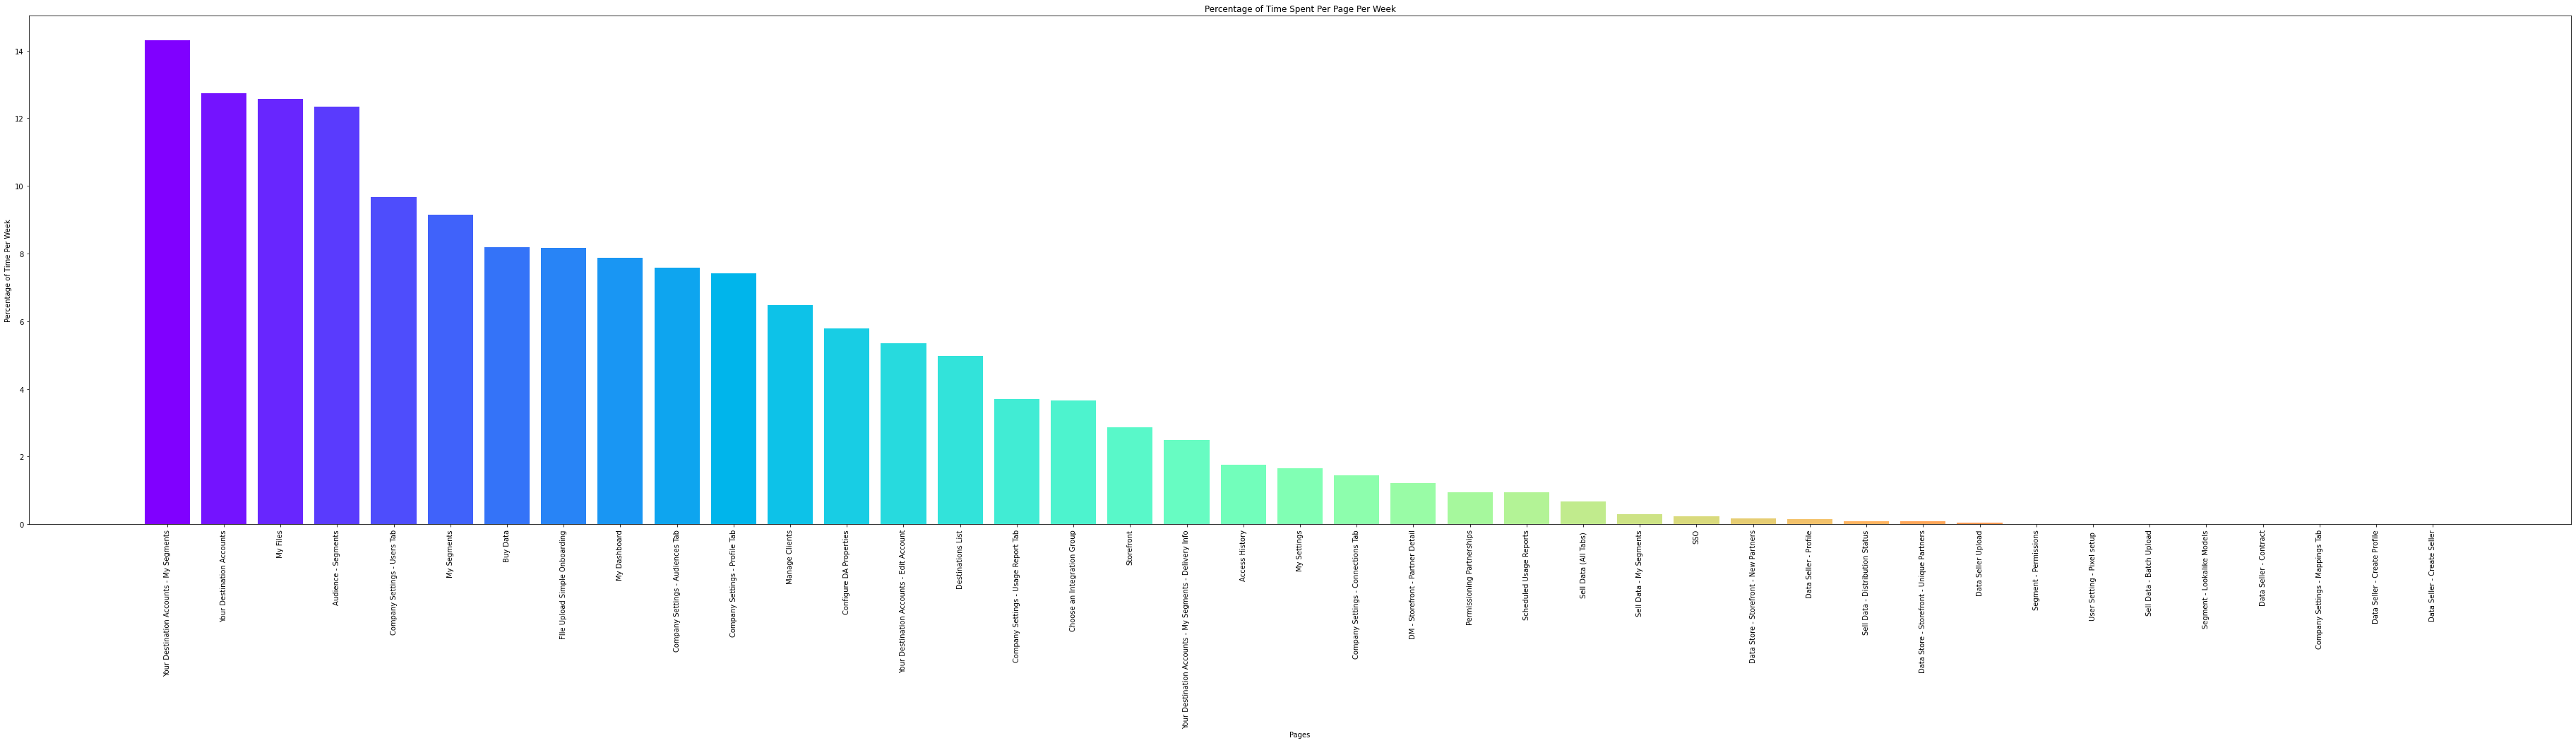

<Figure size 432x288 with 0 Axes>

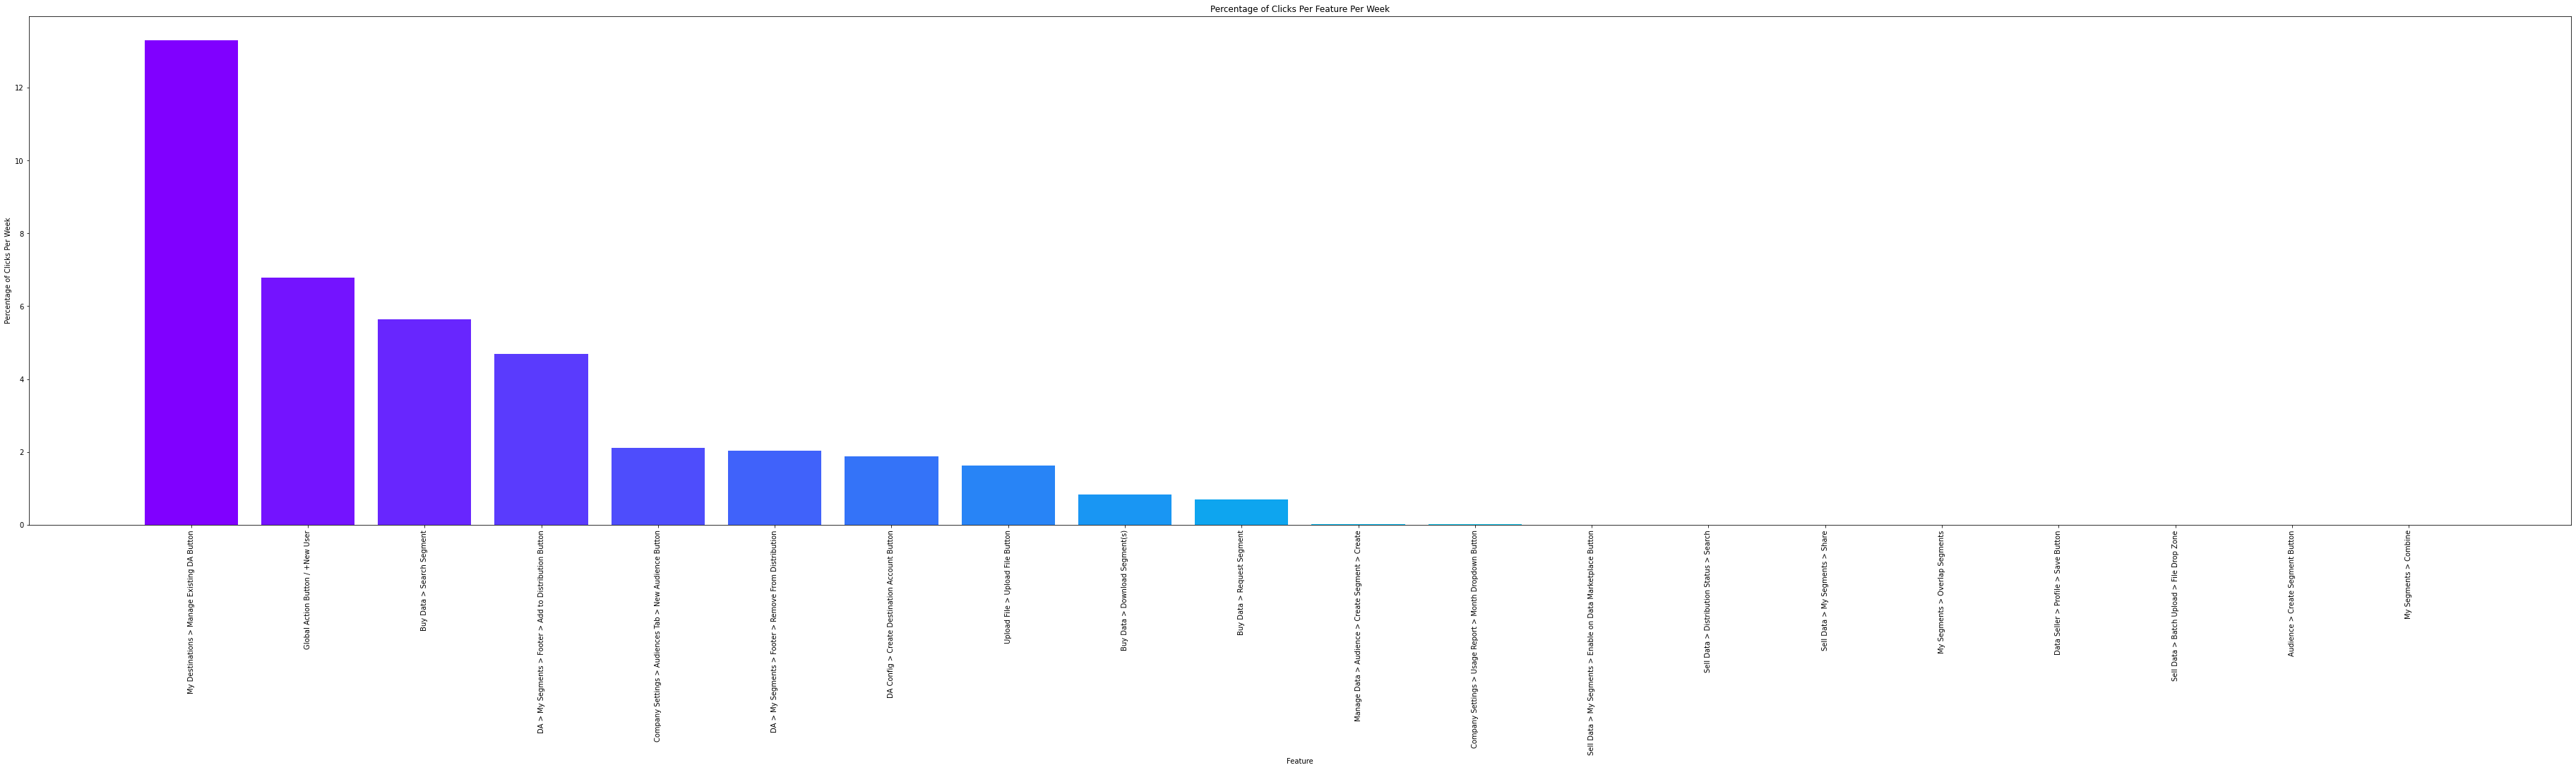

Top Pages on Left, Top Features on Right



,page
name,
Your Destination Accounts - My Segments,14.314030
Your Destination Accounts,12.744009
My Files,12.582974
Audience - Segments,12.351063
Company Settings - Users Tab,9.663632
My Segments,9.150992
Buy Data,8.189307
FIle Upload Simple Onboarding,8.169976
My Dashboard,7.879950




PERSONA CLUSTER: 3 

NUMBER OF USERS IN CLUSTER: 3023.0 

PERCENTAGE OF USERS IN CLUSTER: 47.666 



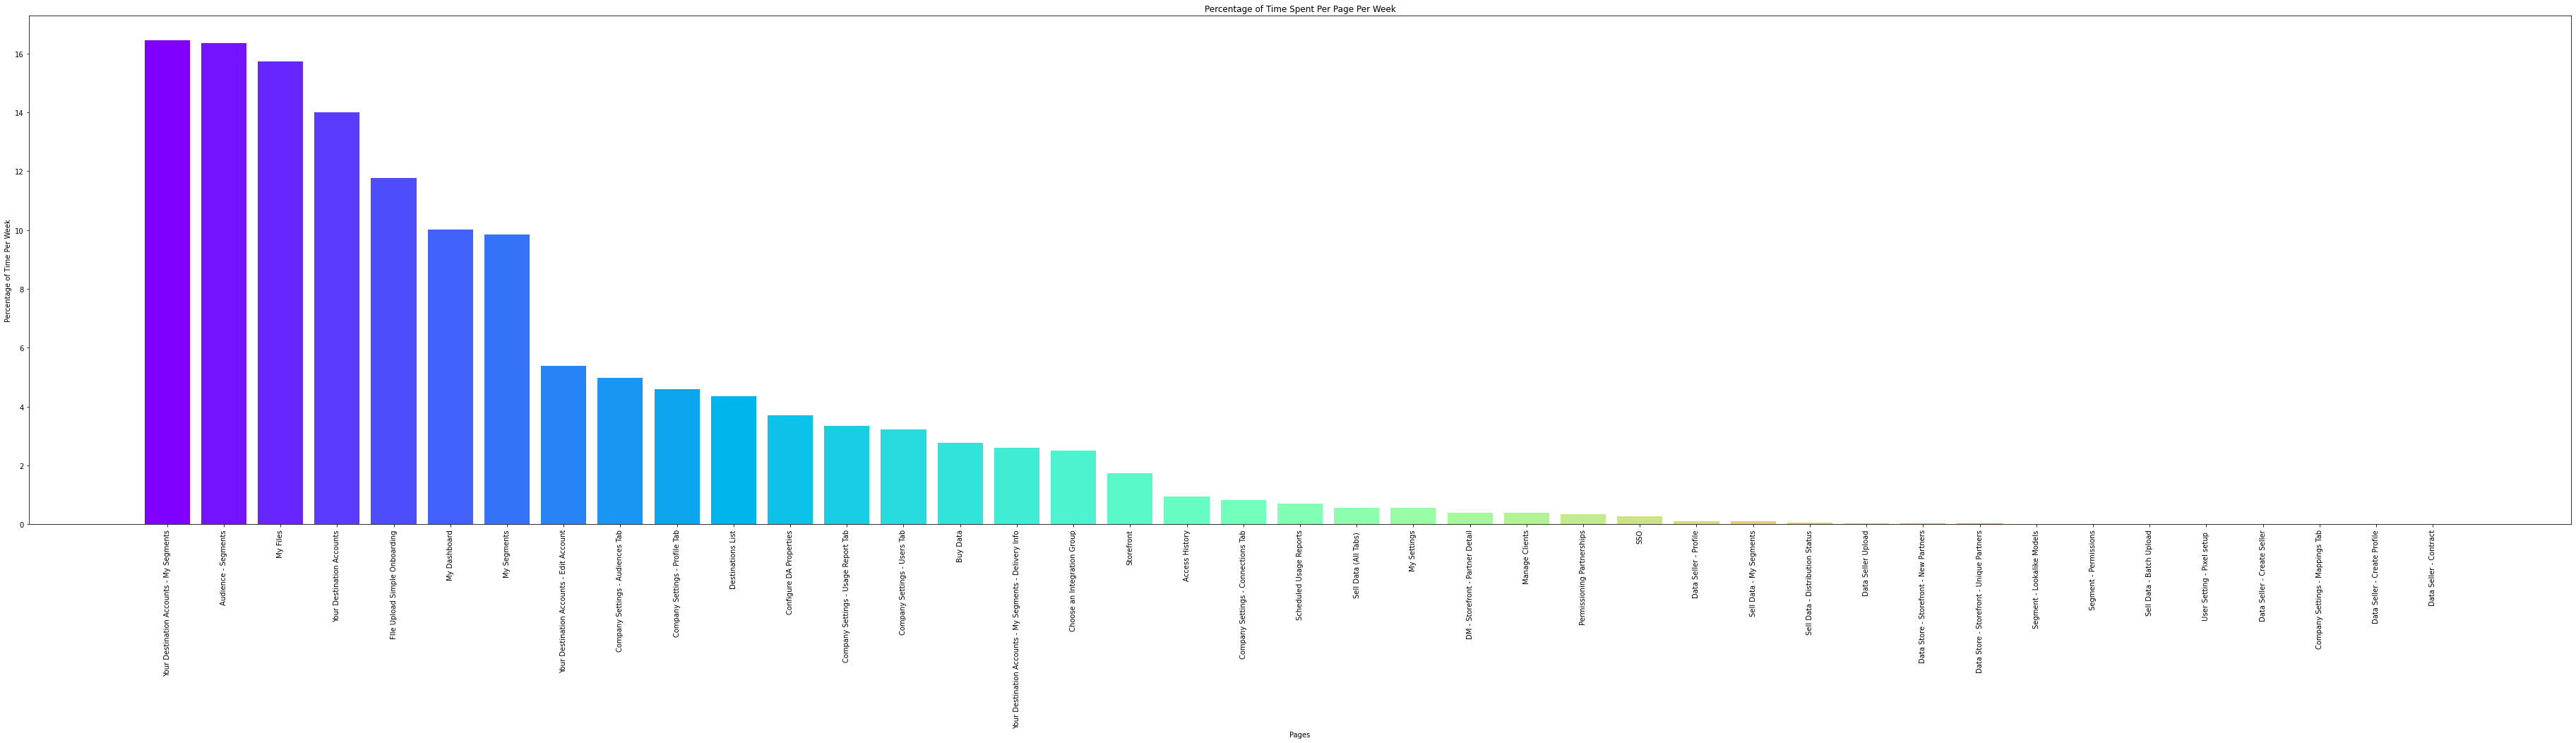

<Figure size 432x288 with 0 Axes>

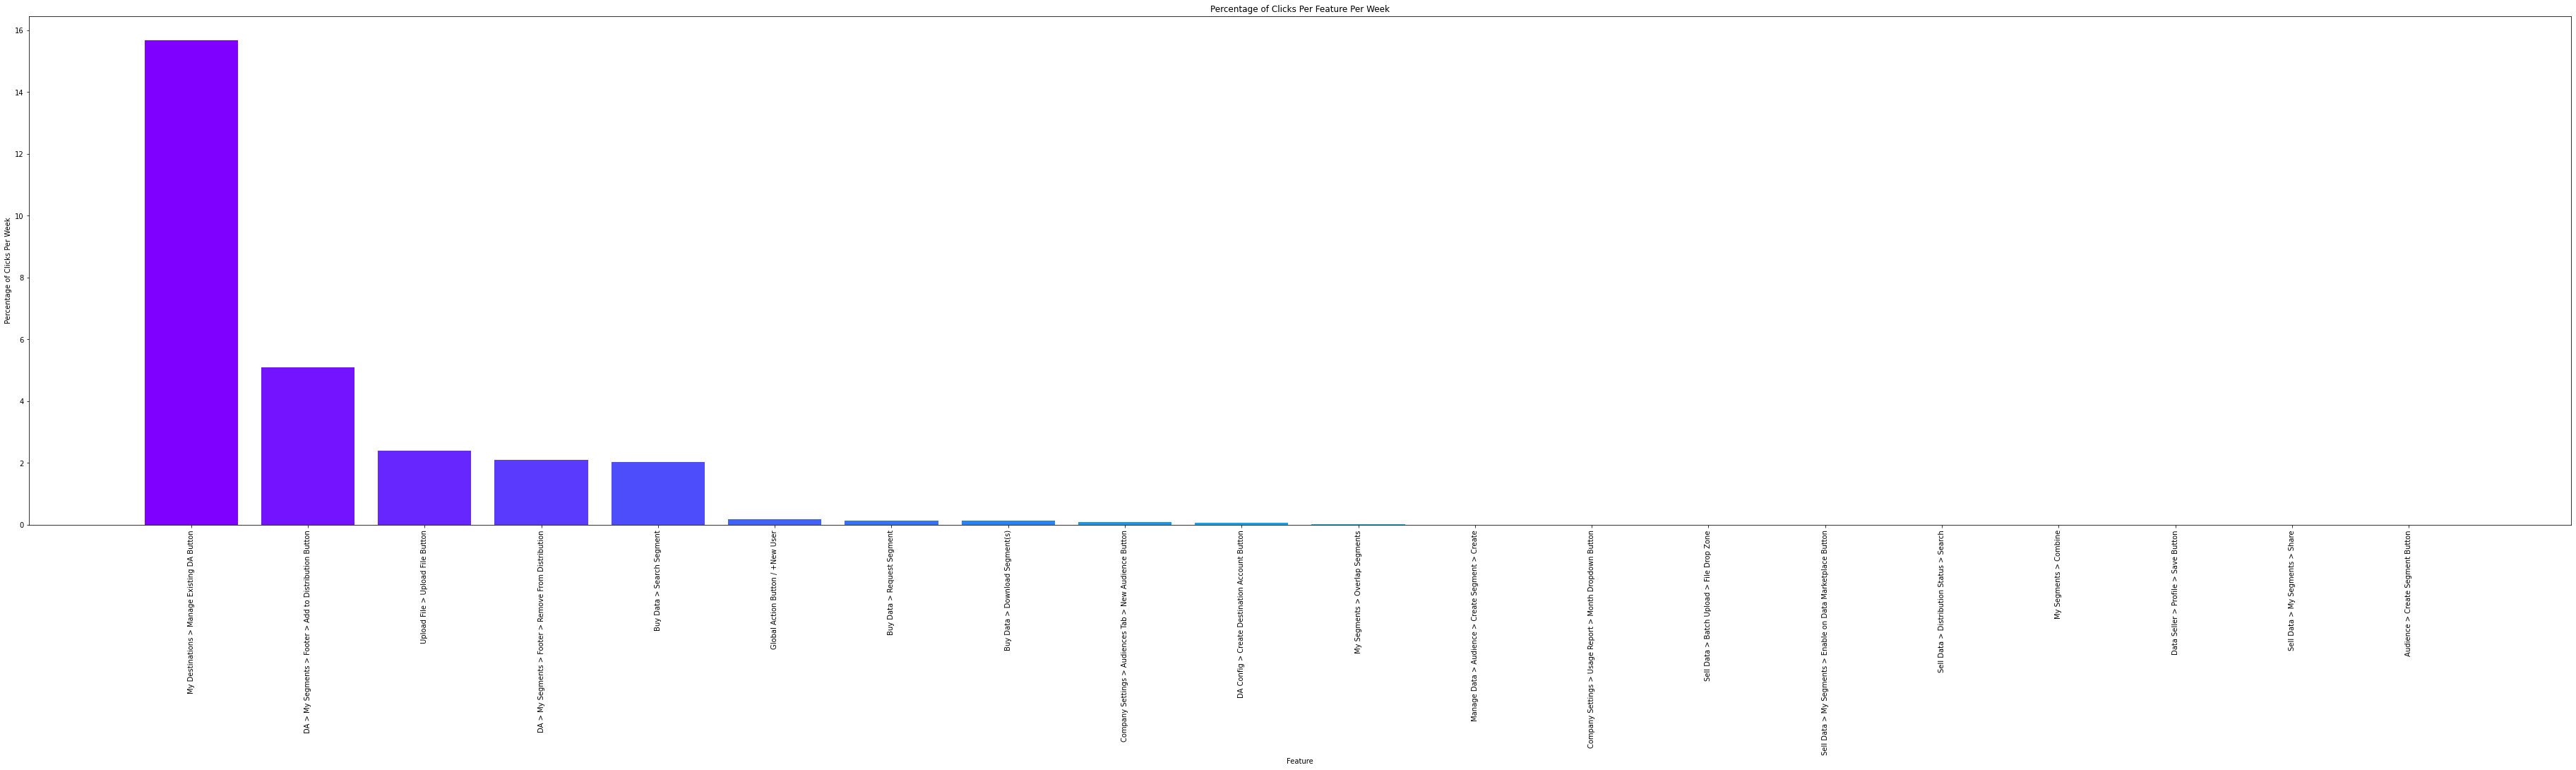

Top Pages on Left, Top Features on Right



,page
name,
Your Destination Accounts - My Segments,16.458640
Audience - Segments,16.344470
My Files,15.735679
Your Destination Accounts,14.000266
FIle Upload Simple Onboarding,11.773811
My Dashboard,10.007548
My Segments,9.836950
Your Destination Accounts - Edit Account,5.395159
Company Settings - Audiences Tab,4.980794


,visitor_id,_tkt5orHUpCVLIts2gorwT3UgG5I,_Ras6hyvLrUgJiRUgon4y1F4QkN4,_zdpPTMNp1EkXtBZR5v_ObuE7hwA,_C3ryON9ItgJ6UgOwQAZmIE8xa3A,_k39G0EasOmyrjXL_x4x8opM1toI,_m3O0KeqVvHCNvjUgwnA1gphjwBM,_3w9IhLaFCwHOywyY2kj6p7kk21Y,_H_1_rGmIvRDj8hnvXi1xwADN5Z4,_V1XJLd_R1gdR0eiF5Y7bThnGjHw,_GID55RO4sNhBCURo7Z1_lY9NLXs,_HbEegssf9k60Mv8lnrdv_889PHc,_IvuCbXKxt9FCXyAxrnqwFhXPFUM,_E_eF9X73IX3ARmERAfLkPPcHMb4,_56iulnmaAqdLQOD_wy_EtdOMLxw,_UHNiLRNy5_VWEPHlDcq1hAr1DTU,_HBzif5IJ9m2SMxfU1JYbpz5hruo,_VwQHIEgwiQ88mTKFEiIfk4a8aCk,_dGro_W0obaKWZs8l_xObcxKmhRg,_GHdt7hBJpluSyeNAQhuekke04S8,_9e_eJvJ3wbmYQlxEI7eadlGc0wA,_CUEn5DTA7EtIh2GfrV6n85e_ugg,_zyt_c4I5PLjo6We_foZiyC0uU8M,_iPN_NrvMGz0wIPCMZV9Vm2CcPyU,_uDfqoLTn6mYspzPtPbKZA4wRtTk,_LQERdzPDKTwyLqEqUOhRLxc2n_Q,_3JO1sgDixw7nC385pm1yyWWHhWw,_vkn0gs9bYzBqFjiHc9wDy5FJbE4,_myTn0VuzM9FtUyijGCGP6Z_vTiI,_hJN6mN74LKulBV6kg7OYGBM5J90,_visitor_id_1,_ASXExEiWYG_cuQMx9_2EiWlxyHE,_oWrmSRLq9EGkbAIMW5m9fefHm3I,_qlIwn8pRkAqQZ4CsWb5CrMTaGwk,_S9AHlZiStX_7kgOPa7XaN5zGKJ0,_BdAAb_f73rZbdntJycUeU30SMSE,_4WVDEkopjfr10pOms_IqOLI8q3A,_JBWNEhtQyWe7tTpphDB1E2_c_Ws,_CqeUW57vNe2GySW9cDdLyLUpufs,_ytijVcqrS7AhGhcFKcJqKtSwju0,...,_Rm7rAxrQI9_98GO7_ygsLiilAJQ,_NVkA8wwWIazlIpp0F4DCCyiG3o8,_P6NCbsdKIKmvIYKMm8uUrW9SOl4,_mxGqjxm536U_BXVu7z8q7zZmbqo,_AhOJz1Ioox06Vkwxv6djw6_1VeI,_QDZaqlR8uko08w45_tKNqFu6SCk,_Ew_SJ8Wdw46lSpx0KWtxA7TNLM4,_LQX8RAc0MobnZb2t_1_UPVKu7LE,_WaknTlZz_pfBrmqFQzzEj1jsIk0,_S9pjvffLNrxBdaR9LqaEZ5QZqOw,_Cx5SRBnNkb1UsbMhxArys4tZPdM,_7oK_B6o_L3kLLreWl1t_K0AyA1w,_t2Ln2u3D5kVaIxItCM9Cf0ahsbg,_kage2OvcmF6fsLCNJwKkDDHpsnw,__0Awg_cExCT_6iYo8MOZvfylGGY,_0bmHn6AFErG41_wmZ6k8PHJBdKE,_3pycSYabKnJw732sx4sue13_IUs,_FNfnbKKkdLypTj8AP_qO86xIyhI,_LE2l5nnwek4rOgiZbFqTuHIdpvc,_Lsz9qFm7N9IY7Jd7Q77PnG4SyP8,_PhDu_gcsFm1BJg7_TZjydBZLUg0,_cyrdB7bfmdofyOVdt1u2z2WfMTc,_e_WTUyY46NogQtZveUrs6E3aNNY,_i0n2sJzuvVQytRBZR0C7lOB8K5s,_jIMa2fYSvuK2S9oOiQA05CMk4BQ,_ocfanzV2X0KG7Z_36cENurW2s4g,_s0BAo4LpGWBZeXuZzBs0iwc9Y3g,_sTKQdz6y7r2BhOm_WA6swZd3DUI,_svSytwZWtEI_EYV7BjI3r7eloLg,_wUizPGfyYcYK73uhW_kPHhaTnXc,_wvwXLR4cYeeVmlTH5NugShsoM2Q,_zNMpq_T5yFVq2JNUeIa0QCHb638,_Y6yU_xYuZvaTeF9rnn0ikSv2i1c,_I_HTE_jumV_8c21faHrx5Biu3V4,_kXjzSeFxT2V9jYVtu6EChsDKWVI,_HP7vebwJnmfbCAUtVJV_wBlWWVc,_lzteCypibweqR_7n4L2h9m9rMBs,_R__S1f92sIxfQT6CMWA558ABGG8,_GeYydM_yIjUfBXDqOvUIFi5b8V0,hdb_scan
0,2311521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.10,3.950000,0.0,27.360000,0.0,0.0,0.0,0.0,0.000000,0.0,27.440000,0.0,0.0,0.0,0.0,0.0,0.0,2311521,0.0,0.000000,0.000000,0.0,0.0,0.900000,0.90,0.00,0.000000,...,3.7,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.266667,3.300000,0.000000,3.550000,0.000000,0.000000,1.900000,2.800000,0.000000,6.100000,2.650000,16.083333,0.000000,0.0,0.000000,28.020000,4.200000,7.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2103499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2103499,0.0,49.063918,12.600000,0.0,0.0,12.409091,0.00,3.55,0.000000,...,0.0,0.00,0.0,8.175000,4.85,0.0,0.0,0.0,0.0,0.0,0.0,1.3,0.0,0.0,0.000000,0.000000,22.124528,0.000000,11.275000,23.344444,3.600000,3.700000,0.000000,0.000000,3.780000,3.500000,0.000000,0.0,0.000000,17.166667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2131589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.25,10.700000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,6.150000,0.0,0.0,0.0,0.0,0.0,0.0,2131589,0.0,0.000000,0.000000,0.0,0.0,1.600000,0.00,0.00,0.000000,...,0.0,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.000000,9.837500,11.711111,0.000000,5.700000,0.000000,5.550000,6.520000,22.200000,9.450000,12.366667,8.100000,0.000000,0.0,13.600000,23.733333,4.300000,8.275000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.46,0.000000,0.0,37.400000,0.0,0.0,0.0,0.0,0.000000,0.0,7.558824,0.0,0.0,0.0,0.0,0.0,0.0,2051329,0.0,2.250000,28.250000,0.0,0.0,2.200000,0.00,0.00,0.000000,...,0.0,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.770000,5.814286,9.034

In [ ]:
hdb_scan(X, X_normalized, "hdb_scan", 40, 0.0, 2, 15, 500)

In [ ]:
#Since the generalist persona has the broadest set of responsibilites and largest size
#Let's assess whether there is a subpersona that can be identified when looking at a smaller subset of data
generalist = (X["hdb_scan"] == 3)

In [ ]:
#Identify just the advtv features
no_dis_df = id_name_mapping[id_name_mapping["app"] == "connect"]

#Non distribution and advtv page names, page ids, feature names, and feature ids
page_names = no_dis_df[no_dis_df["type"] == "page"]["name"]
p_ids = no_dis_df[no_dis_df["type"] == "page"]["reformatted_id"]
feature_names = no_dis_df[no_dis_df["type"] == "feature"]["name"]
f_ids = no_dis_df[no_dis_df["type"] == "feature"]["reformatted_id"]

In [ ]:
#Identify the advanced tv users who are too small to warrant their on cluster in the above clustering iteration
#But are known to be distinct due to qualitative data and user interviews
%%bigquery --project uxr-design-us-dev advtv_users
SELECT distinct visitor_id FROM `mixed_methods_clustering.all_features_telemetry_data_per_week_deduped`
WHERE app = "advanced_tv"

UNION ALL 

SELECT distinct visitor_id FROM `mixed_methods_clustering.all_pages_telemetry_data_per_week_deduped`
WHERE app = "advanced_tv"

In [ ]:
#Remove the advanced TV users from the dataset and the distribution features; 
#Look only at the generalist users and remove features that might be overpowering other signals in the data
tv_users = advtv_users["visitor_id"].to_list() #TV users
filtered_ids = np.append(p_ids, f_ids) #Non distribution (our core workflow) features

#Select just the generalist persona, removing those that we identify as tv users, with only the more focused features
Y = X[~(X["visitor_id"].isin(tv_users)) & generalist][ids].copy()

In [ ]:
# Scaling the data to bring all the attributes to a comparable level
scaler = StandardScaler()
Y_scaled = scaler.fit_transform(Y[ids])

# Normalizing the data so that the data
# approximately follows a Gaussian distribution
Y_normalized = normalize(Y_scaled)

# Converting the numpy array into a pandas DataFrame
Y_normalized = pd.DataFrame(Y_normalized)

# Renaming the columns
Y_normalized.columns = Y[ids].columns

Percent Clustered: 52


PERSONA CLUSTER: 0 

NUMBER OF USERS IN CLUSTER: 1075.0 

PERCENTAGE OF USERS IN CLUSTER: 35.584 



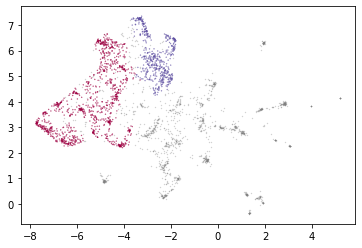

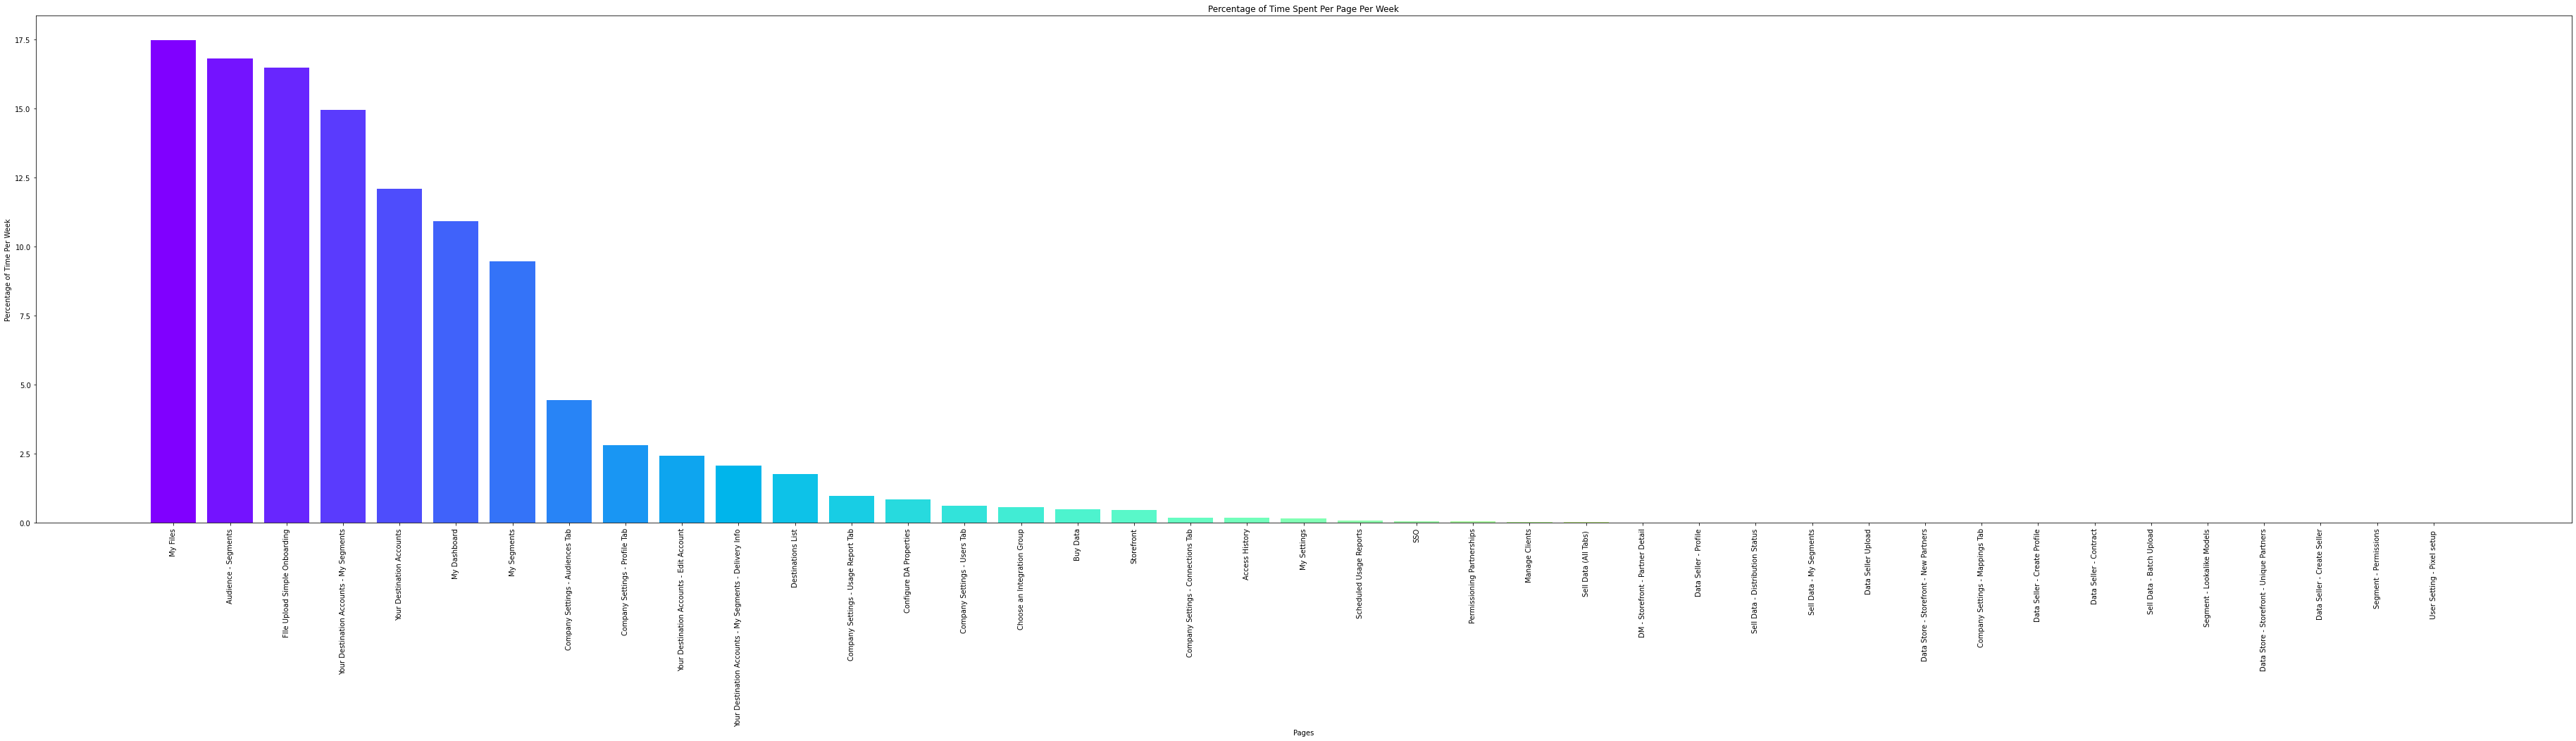

<Figure size 432x288 with 0 Axes>

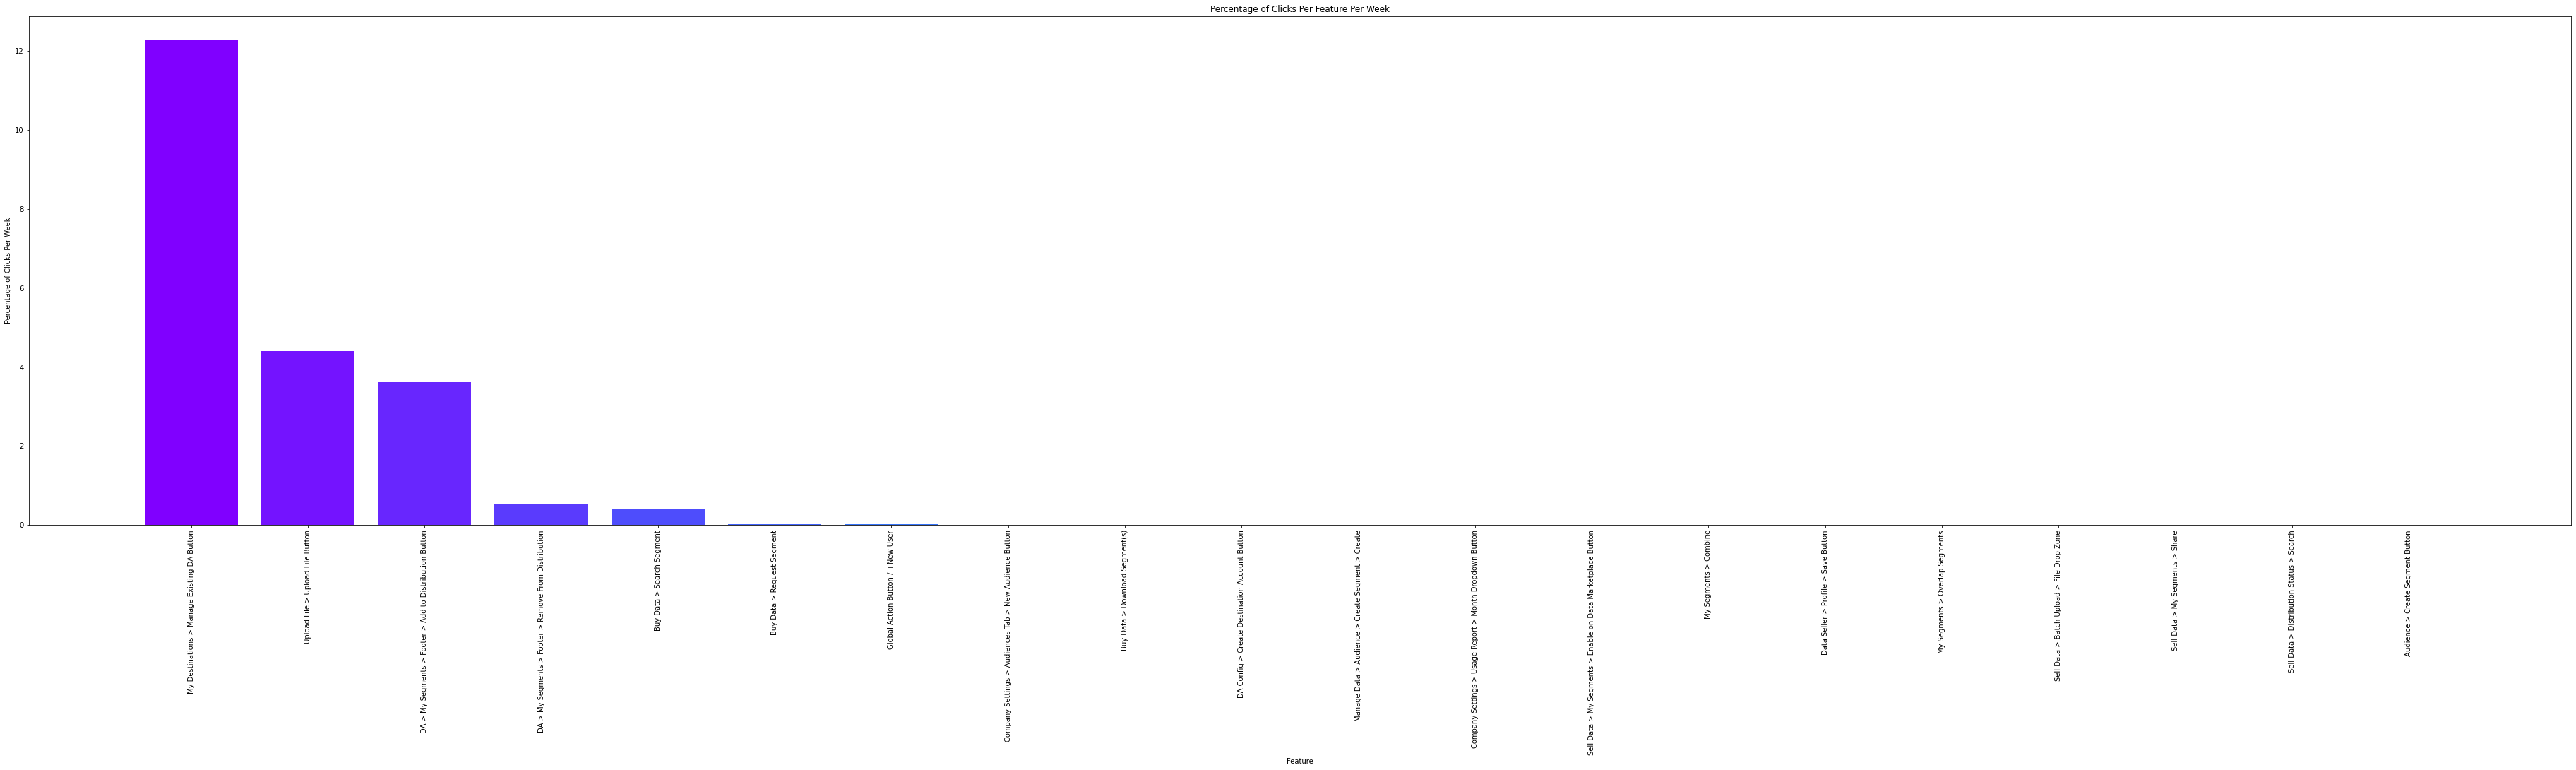

Top Pages on Left, Top Features on Right



,page
name,
My Files,17.491468
Audience - Segments,16.829118
FIle Upload Simple Onboarding,16.493959
Your Destination Accounts - My Segments,14.956707
Your Destination Accounts,12.094123
My Dashboard,10.924762
My Segments,9.467416
Company Settings - Audiences Tab,4.435966
Company Settings - Profile Tab,2.820731




PERSONA CLUSTER: 1 

NUMBER OF USERS IN CLUSTER: 522.0 

PERCENTAGE OF USERS IN CLUSTER: 17.279 



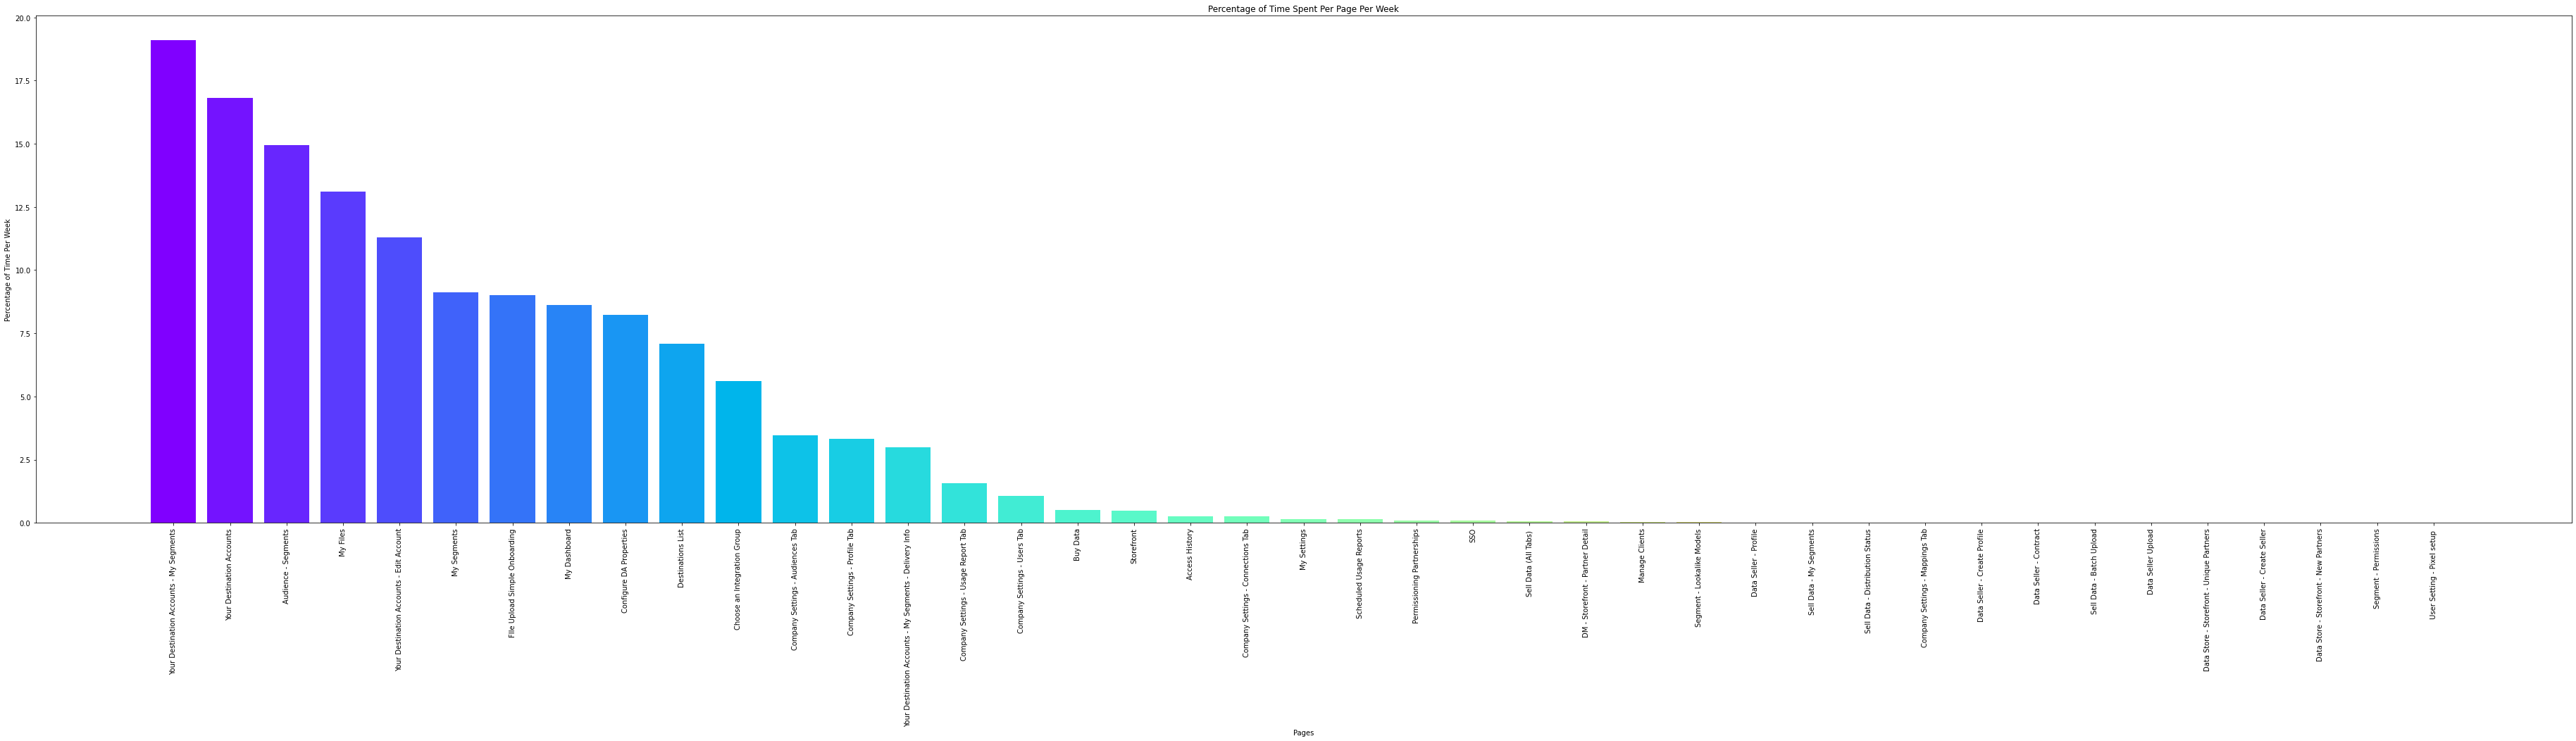

<Figure size 432x288 with 0 Axes>

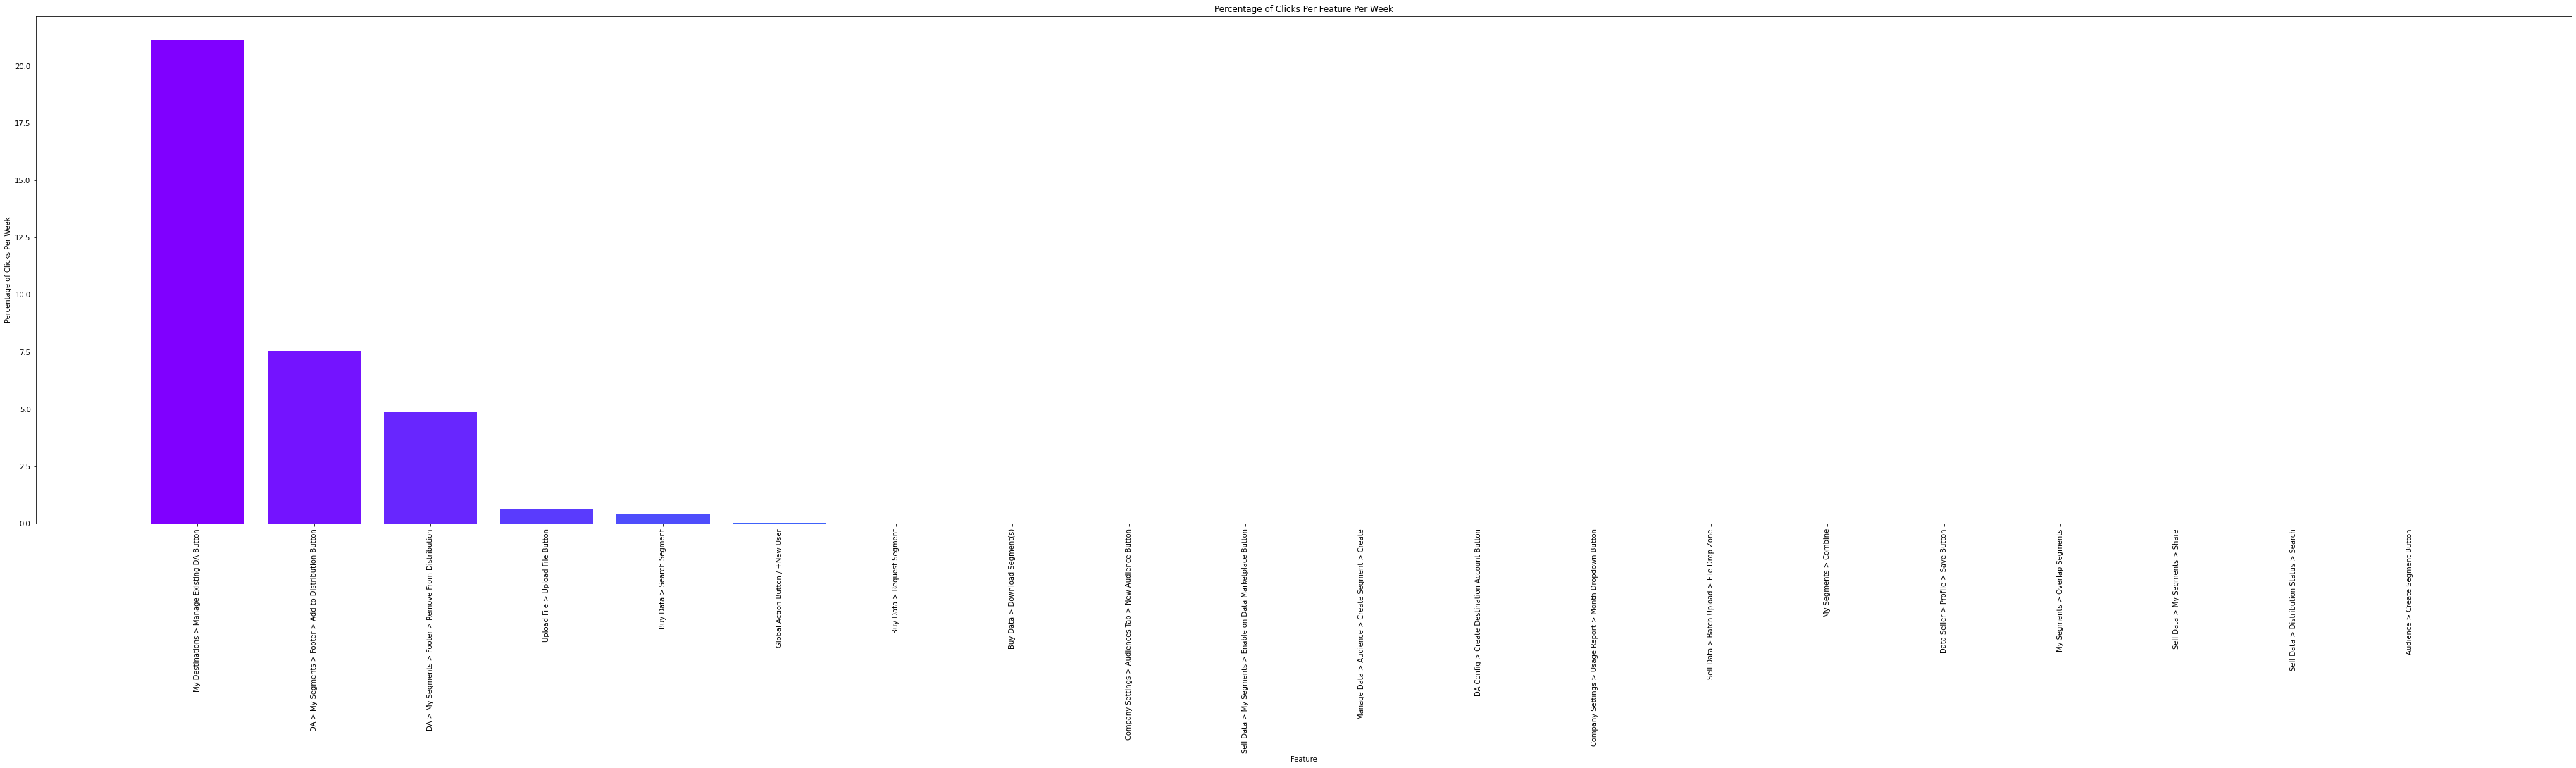

Top Pages on Left, Top Features on Right



,page
name,
Your Destination Accounts - My Segments,19.111273
Your Destination Accounts,16.810905
Audience - Segments,14.959235
My Files,13.106198
Your Destination Accounts - Edit Account,11.296776
My Segments,9.128990
FIle Upload Simple Onboarding,9.023625
My Dashboard,8.623950
Configure DA Properties,8.243503


,_tkt5orHUpCVLIts2gorwT3UgG5I,_Ras6hyvLrUgJiRUgon4y1F4QkN4,_zdpPTMNp1EkXtBZR5v_ObuE7hwA,_C3ryON9ItgJ6UgOwQAZmIE8xa3A,_k39G0EasOmyrjXL_x4x8opM1toI,_m3O0KeqVvHCNvjUgwnA1gphjwBM,_3w9IhLaFCwHOywyY2kj6p7kk21Y,_H_1_rGmIvRDj8hnvXi1xwADN5Z4,_V1XJLd_R1gdR0eiF5Y7bThnGjHw,_GID55RO4sNhBCURo7Z1_lY9NLXs,_HbEegssf9k60Mv8lnrdv_889PHc,_IvuCbXKxt9FCXyAxrnqwFhXPFUM,_E_eF9X73IX3ARmERAfLkPPcHMb4,_56iulnmaAqdLQOD_wy_EtdOMLxw,_UHNiLRNy5_VWEPHlDcq1hAr1DTU,_HBzif5IJ9m2SMxfU1JYbpz5hruo,_VwQHIEgwiQ88mTKFEiIfk4a8aCk,_dGro_W0obaKWZs8l_xObcxKmhRg,_GHdt7hBJpluSyeNAQhuekke04S8,_9e_eJvJ3wbmYQlxEI7eadlGc0wA,_CUEn5DTA7EtIh2GfrV6n85e_ugg,_zyt_c4I5PLjo6We_foZiyC0uU8M,_iPN_NrvMGz0wIPCMZV9Vm2CcPyU,_uDfqoLTn6mYspzPtPbKZA4wRtTk,_LQERdzPDKTwyLqEqUOhRLxc2n_Q,_3JO1sgDixw7nC385pm1yyWWHhWw,_vkn0gs9bYzBqFjiHc9wDy5FJbE4,_myTn0VuzM9FtUyijGCGP6Z_vTiI,_hJN6mN74LKulBV6kg7OYGBM5J90,_ASXExEiWYG_cuQMx9_2EiWlxyHE,_oWrmSRLq9EGkbAIMW5m9fefHm3I,_qlIwn8pRkAqQZ4CsWb5CrMTaGwk,_S9AHlZiStX_7kgOPa7XaN5zGKJ0,_BdAAb_f73rZbdntJycUeU30SMSE,_4WVDEkopjfr10pOms_IqOLI8q3A,_JBWNEhtQyWe7tTpphDB1E2_c_Ws,_CqeUW57vNe2GySW9cDdLyLUpufs,_ytijVcqrS7AhGhcFKcJqKtSwju0,_U8uusnL75FDx5Qy9gEV4YYpSJls,_wnkmLUff1uBbQNXIfS7V1fzkcGs,...,_Rm7rAxrQI9_98GO7_ygsLiilAJQ,_NVkA8wwWIazlIpp0F4DCCyiG3o8,_P6NCbsdKIKmvIYKMm8uUrW9SOl4,_mxGqjxm536U_BXVu7z8q7zZmbqo,_AhOJz1Ioox06Vkwxv6djw6_1VeI,_QDZaqlR8uko08w45_tKNqFu6SCk,_Ew_SJ8Wdw46lSpx0KWtxA7TNLM4,_LQX8RAc0MobnZb2t_1_UPVKu7LE,_WaknTlZz_pfBrmqFQzzEj1jsIk0,_S9pjvffLNrxBdaR9LqaEZ5QZqOw,_Cx5SRBnNkb1UsbMhxArys4tZPdM,_7oK_B6o_L3kLLreWl1t_K0AyA1w,_t2Ln2u3D5kVaIxItCM9Cf0ahsbg,_kage2OvcmF6fsLCNJwKkDDHpsnw,__0Awg_cExCT_6iYo8MOZvfylGGY,_0bmHn6AFErG41_wmZ6k8PHJBdKE,_3pycSYabKnJw732sx4sue13_IUs,_FNfnbKKkdLypTj8AP_qO86xIyhI,_LE2l5nnwek4rOgiZbFqTuHIdpvc,_Lsz9qFm7N9IY7Jd7Q77PnG4SyP8,_PhDu_gcsFm1BJg7_TZjydBZLUg0,_cyrdB7bfmdofyOVdt1u2z2WfMTc,_e_WTUyY46NogQtZveUrs6E3aNNY,_i0n2sJzuvVQytRBZR0C7lOB8K5s,_jIMa2fYSvuK2S9oOiQA05CMk4BQ,_ocfanzV2X0KG7Z_36cENurW2s4g,_s0BAo4LpGWBZeXuZzBs0iwc9Y3g,_sTKQdz6y7r2BhOm_WA6swZd3DUI,_svSytwZWtEI_EYV7BjI3r7eloLg,_wUizPGfyYcYK73uhW_kPHhaTnXc,_wvwXLR4cYeeVmlTH5NugShsoM2Q,_zNMpq_T5yFVq2JNUeIa0QCHb638,_Y6yU_xYuZvaTeF9rnn0ikSv2i1c,_I_HTE_jumV_8c21faHrx5Biu3V4,_kXjzSeFxT2V9jYVtu6EChsDKWVI,_HP7vebwJnmfbCAUtVJV_wBlWWVc,_lzteCypibweqR_7n4L2h9m9rMBs,_R__S1f92sIxfQT6CMWA558ABGG8,_GeYydM_yIjUfBXDqOvUIFi5b8V0,hdb_generalist
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.100000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,24.444444,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.700000,0.00,0.0,18.7375,0.000000,0.000000,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.016667,0.000000,23.450000,25.700000,13.000000,0.0,9.666667,0.000000,15.475000,0.000000,18.227273,16.955556,26.367500,0.0,0.000000,21.700000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000,0.00,0.0,2.4,0.0,0.0,0.0,0.0,0.000000,0.0,10.081667,0.0,7.975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.800000,0.00,0.0,0.0000,2.750000,3.400000,...,0.0,4.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.689831,6.942857,16.139175,6.888889,4.300000,0.0,9.988889,5.122222,31.016667,6.628571,17.930435,13.455422,33.038854,0.0,8.800000,10.800000,10.000000,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.900000,1.94,0.0,6.5,0.0,0.0,0.0,0.0,0.000000,0.0,10.950000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,1.2000,0.000000,0.000000,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.071429,0.000000,0.000000,0.000000,1.933333,0.0,0.000000,0.000000,0.400000,0.000000,2.400000,23.333333,2.600000,0.0,0.000000,10.928571,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.350000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,8.294366,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.975000,4.30,3.2,5.9000,19.085714,8.566667,...,0.0,13.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.262500,6.248649,21.128205,5.411429,5.020000,0.0,7.715000,5.246667,1

In [ ]:
hdb_scan(Y, Y_normalized, "hdb_generalist", 40, 0.0, 2, 15, 500)